# Définissions

In [ ]:
# %load_ext autoreload
# %autoreload 2

import sys
import os

# Ajoute le dossier "src" au path
src_path = os.path.abspath("..")
if src_path not in sys.path:
    sys.path.append(src_path)

# Data manipulation
import pandas as pd
import numpy as np
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reducer
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin

# Models fine tuning
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import f1_score

# Custom
import importlib
from utils.result_helper import save_result, display_result
import utils.helper as helper 

from nltk.tokenize import TweetTokenizer

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import make_scorer, f1_score

# Step 1

## Importation of the dataset

In [40]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.StepConfig = helper.ConfigLoader.load_step1()

df_path= "../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

## Preprocessing
1. On définit les préprocessings de la donnée

In [ ]:
def emoji_processing(X: DataFrame) -> DataFrame:
	def count_emojis(text: str) -> int:
		return sum(1 for char in text if char in emoji.EMOJI_DATA)
	def replace_emojis(text: str) -> str:
		return emoji.demojize(text, delimiters=(" ", " "))
	
	X["emoji_count"] = X["text"].apply(count_emojis)
	X["text"] = X["text"].apply(replace_emojis).astype("string")
	return X
	
def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', 'url', text)
	
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link).astype("string")
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
    X["hashtag_count"] = X["text"].apply(lambda x: len(re.findall(r'#\w+', x)))
    X["text"] = X["text"].apply(lambda x: re.sub(r'#(\w+)', r'\1', x)).astype("string")
    
    return X

def mention_processing(X: DataFrame) -> DataFrame:
	def count_mentions(text: str) -> int:
		return len(re.findall(r'@\w+', text))
	
	def replace_mentions(text: str) -> str:
		return re.sub(r'@\w+', 'mention', text)

	X["mention_count"] = X["text"].apply(count_mentions)
	X["text"] = X["text"].apply(replace_mentions).astype("string")
	return X

def number_processing(X: DataFrame) -> DataFrame:
	X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
	return X


def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X["text"] = X["text"].apply(preprocess).astype("string")
	return X

In [7]:
class KeywordFeatures(BaseEstimator, TransformerMixin):
	def __init__(self, n_keywords=10, verbose = False):
		self.keyword_categories = {
			"science": [],
			"non_science": []
		}
		self.n_keywords = n_keywords
		self.verbose = verbose
		self.regex_patterns = {}

	def _extract_category_keywords(self, text, category):
			return [word for word, pattern in self.regex_patterns[category].items() if pattern.search(text)]
	
	def _extract_top_keywords(self, text_series):
		"""
		Extrait les n mots les plus fréquents d'une série de textes.
		Le texte est supposé être déjà lemmatisé.
		"""
		combined_text = " ".join(text_series)
		tokens = re.findall(r'\b\w+\b', combined_text.lower())
		word_counts = Counter(tokens)
		filtered_counts = {word: count for word, count in word_counts.items() if len(word) >= 3}
		
		return [word for word, _ in Counter(filtered_counts).most_common(self.n_keywords * 2)]
	
	def fit(self, X: DataFrame, y:DataFrame):
		science_texts = X.loc[y == 1, 'text'].astype(str)
		non_science_texts = X.loc[y == 0, 'text'].astype(str)

		science_keywords = self._extract_top_keywords(science_texts)
		non_science_keywords = self._extract_top_keywords(non_science_texts)

		# on supprime les mots communs
		common_keywords = set(science_keywords) & set(non_science_keywords)
		science_keywords = [word for word in science_keywords if word not in common_keywords]
		non_science_keywords = [word for word in non_science_keywords if word not in common_keywords]

		self.keyword_categories["science"] = science_keywords[:self.n_keywords]
		self.keyword_categories["non_science"] = non_science_keywords[:self.n_keywords]

		self.regex_patterns = {
            category: {word: re.compile(r'\b' + word + r'\b', re.IGNORECASE) 
                      for word in words}
            for category, words in self.keyword_categories.items()
        }
		
		if self.verbose :
			print("Mots-clés science:", self.keyword_categories["science"])
			print("Mots-clés non-science:", self.keyword_categories["non_science"])

		return self

	def transform(self, X: DataFrame):
		X_transformed = X.copy()
		
		for category in self.keyword_categories:
			X_transformed[f"{category}_keyword_count"] = X["text"].apply(
				lambda x: len(self._extract_category_keywords(x, category))
			).astype(int)
		
		return X_transformed
	
	def fit_transform(self, X: DataFrame, y:DataFrame):
		self.fit(X, y)
		return self.transform(X)

2. On pre-processed le data
   
C'est très facile d'activer ou désactiver une feature

In [8]:
df = df_base.copy()
df = hashtag_processing(df)
df = mention_processing(df)
df = emoji_processing(df)
df = link_processing(df)
df = number_processing(df)
df = pre_processing(df)

In [9]:
X = df.copy().drop(columns=["scientific_claim", "scientific_reference", "scientific_context"])
y = X.pop("science_related")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)
X_train.head()

,text,hashtag_count,mention_count,emoji_count,link_count,numbers_count
867,mention smoking cannabis help control nausea c...,0,1,0,0,0
831,kid wear sunglass support classmate battle eye...,0,0,0,1,0
1057,mention mention thank yes reaction lead big mo...,0,2,0,0,0
1118,kaiser stop lurk useless expect tribute 10 min...,0,0,0,0,1
654,$ imgn immunogen report recent progress quarte...,0,0,0,0,1


In [10]:
print("\nDataset information:\n")
print(X_train.info())


Dataset information:

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 867 to 275
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           912 non-null    string
 1   hashtag_count  912 non-null    int64 
 2   mention_count  912 non-null    int64 
 3   emoji_count    912 non-null    int64 
 4   link_count     912 non-null    int64 
 5   numbers_count  912 non-null    int64 
dtypes: int64(5), string(1)
memory usage: 49.9 KB
None


## Evaluation des classifiers sans tunning avec TF-IDF & Bag of words

On va utiliser une classe python, qui va essayer a tour de role, les classifiers sans tuning des paramètres, d'abord avec une vectorisation TF-IDF puis avec Bag of words.

On a choisit la validation croisée sur le training set pour estimer la performance et la variabilité des modèles et de selectionner les plus prometteur.

ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


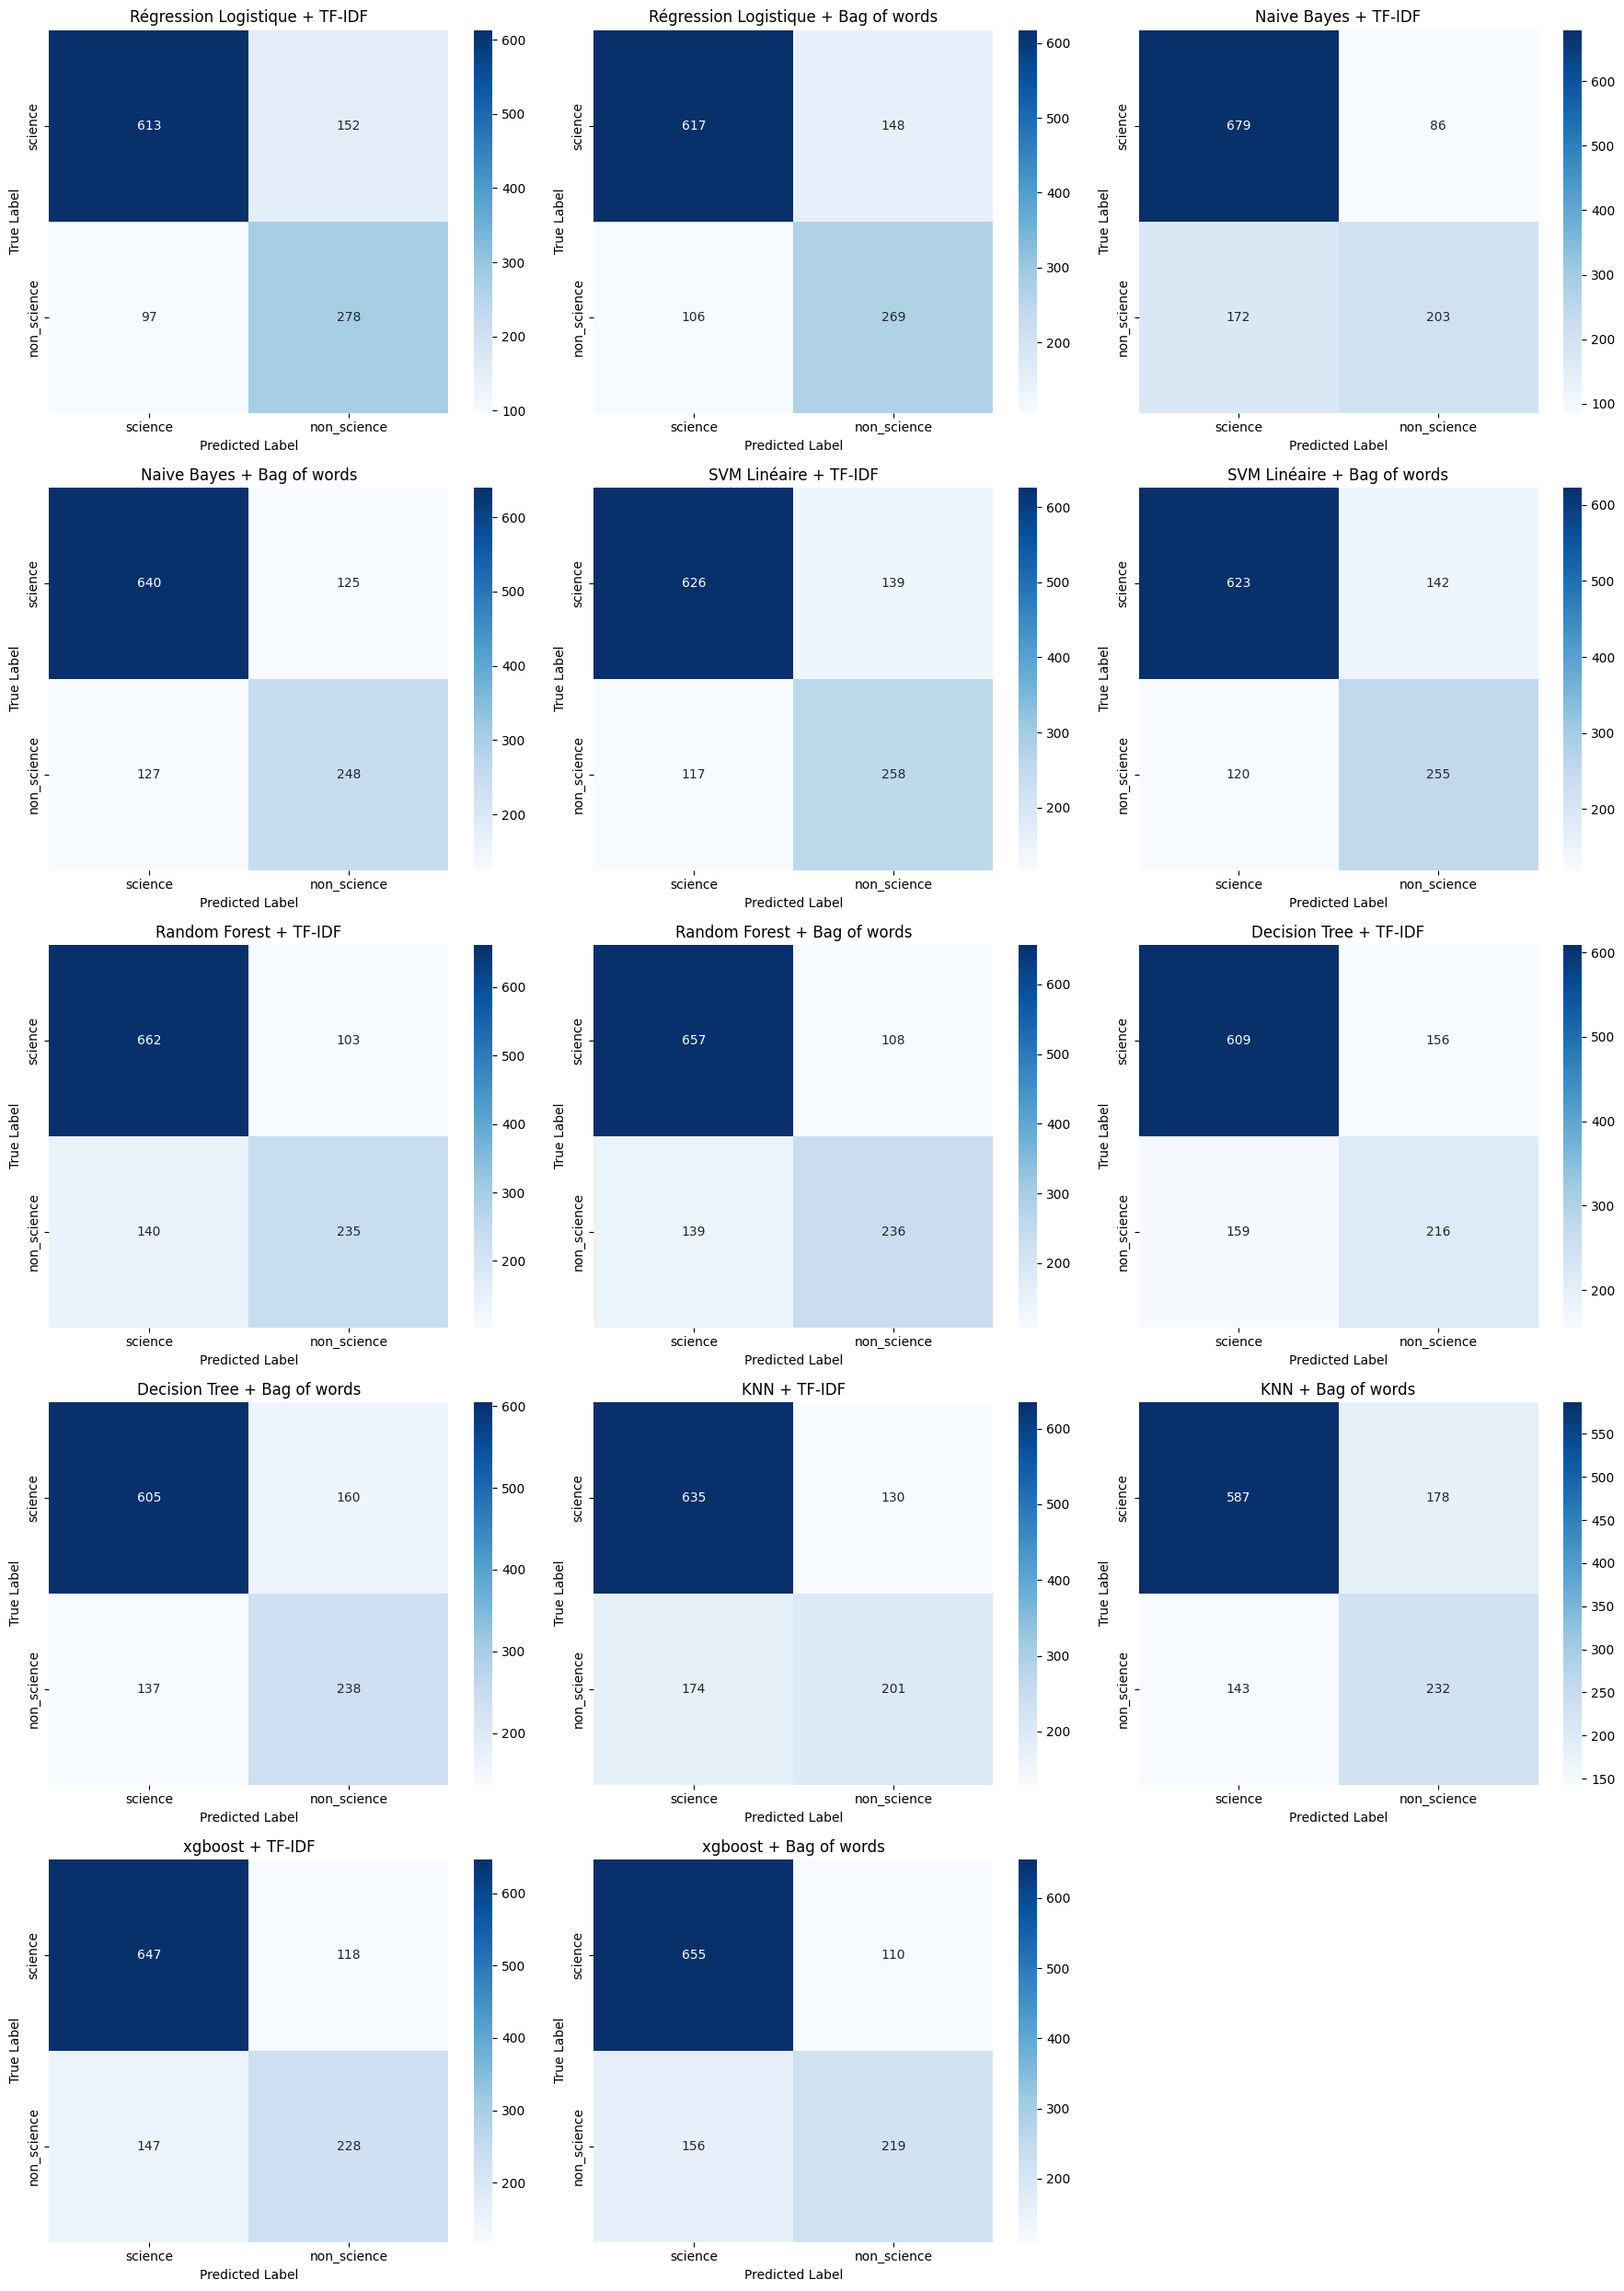

,Classifier,Vectorizer,F1 Mean,F1 Std
0,Régression Logistique,TF-IDF,0.760,0.032
1,Régression Logistique,Bag of words,0.754,0.042
6,Random Forest,TF-IDF,0.750,0.044
3,Naive Bayes,Bag of words,0.749,0.030
4,SVM Linéaire,TF-IDF,0.749,0.035
7,Random Forest,Bag of words,0.747,0.048
5,SVM Linéaire,Bag of words,0.742,0.042
12,xgboost,TF-IDF,0.731,0.034
2,Naive Bayes,TF-IDF,0.725,0.022
13,xgboost,Bag of words,0.725,0.037


In [13]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X, y,  KeywordFeatures(15, verbose=False), config, ["science", "non_science"],)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

## Tuning des hyperparamètres des 3 classifiers
1. Naive Bayes & Bag of words
2. Régression Logistique & Bag of words
3. Random Forest & Bag of words

#### Définitions de fonctions

In [14]:
ngram_options = {
	"unigram": (1, 1),
	"bigram": (1, 2),
	"trigram": (1, 3),
	"quadrugram": (1, 4)
}
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()
text_col = "text"

In [15]:
def visualize_data_with_pca(X_test, y_test, pipeline, title="PCA des données", n_components = 2):
	"""
	Visualise les données transformées avec PCA et colore par classe
	"""
	# 1. Transformer les données avec le préprocesseur du pipeline
	preprocessor = pipeline.named_steps['preprocessor']
	X_transformed = preprocessor.transform(X_test)
	
	# Si la matrice est sparse, la convertir en dense
	if hasattr(X_transformed, "toarray"):
		X_dense = X_transformed.toarray()
	else:
		X_dense = X_transformed
	
	# 2. Appliquer PCA pour réduire à 2 dimensions
	pca = PCA(n_components=n_components)
	X_pca = pca.fit_transform(X_dense)
	
	# 3. Créer un DataFrame pour la visualisation
	df_plot = pd.DataFrame({
		'PC1': X_pca[:, 0],
		'PC2': X_pca[:, 1],
		'Class': y_test.values
	})
	
	# 4. Visualiser avec un scatter plot
	plt.figure(figsize=(10, 8))
	sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Class', 
				   palette={0: "red", 1: "blue"},s=60)
	
	# 5. Ajouter des informations sur la variance expliquée
	explained_var = pca.explained_variance_ratio_
	plt.xlabel(f'PC1 ({explained_var[0]:.2%} variance expliquée)')
	plt.ylabel(f'PC2 ({explained_var[1]:.2%} variance expliquée)')
	plt.title(f'{title}\nVariance totale expliquée: {sum(explained_var):.2%}')
	
	# 6. Ajouter une légende
	plt.legend(title="Classe", labels=["Non-scientifique", "Scientifique"])
	
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.plot()

	return X_pca

from sklearn.utils import resample

def get_score(pipeline, n_iterations=100):
    f1_scores = []
    
    for i in range(n_iterations):
        indices = resample(range(len(X_test)), replace=True, n_samples=len(X_test))
        X_boot = X_test.iloc[indices] if hasattr(X_test, 'iloc') else X_test[indices]
        y_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]

        y_pred = pipeline.predict(X_boot)
        f1 = f1_score(y_boot, y_pred, average='macro')
        f1_scores.append(f1)
    
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    print(f"✅ F1-score (bootstrap sur test, {n_iterations} itérations): {f1_mean:.3f} ± {f1_std:.3f}")
    return f1_mean, f1_std

def get_vectorizer(vectorizer_type, ngram_key, min_df, max_features):
	if vectorizer_type == "tfidf":
		return TfidfVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)
	return CountVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)

def get_trial_score(classifier, vectorizer, n_keywords, scaling = True):
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, "text"),
			("num", StandardScaler() if scaling else "passthrough", numerical_cols)
		]
	)
	
	pipeline = Pipeline([
		("keywords", KeywordFeatures(n_keywords)),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	return  cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()


def get_pipeline(model, classifier, scaler = True):
	vectorizer = model.get_vectorizer()
	numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

	
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, text_col),
			("num", StandardScaler() if scaler else "passthrough", numerical_cols)
		]
	)

	return Pipeline([
		("keywords", KeywordFeatures(model.get_config("n_keywords"))),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

#### Naive Bayes avec Bag of words

In [16]:
def objective(trial):
	alpha = trial.suggest_float("alpha", 1e-3, 2.0, log=True)
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	 

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(MultinomialNB(alpha=alpha), vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 18:47:35,666] A new study created in memory with name: no-name-92d92ba5-3ad1-4940-bcdf-3b8f9e456c61


In [18]:
study.optimize(objective, n_trials=50)
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("NB", study.best_params)

[I 2025-05-06 18:48:37,089] Trial 50 finished with value: 0.7495179094913963 and parameters: {'alpha': 0.09746023628938642, 'ngram_range': 'quadrugram', 'min_df': 2, 'max_features': 16000, 'n_keywords': 10, 'vectorizer_type': 'bow'}. Best is trial 36 with value: 0.7621412712347954.
[I 2025-05-06 18:48:37,723] Trial 51 finished with value: 0.7597433417503066 and parameters: {'alpha': 0.3277571047926348, 'ngram_range': 'quadrugram', 'min_df': 1, 'max_features': 11000, 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 36 with value: 0.7621412712347954.
[I 2025-05-06 18:48:38,476] Trial 52 finished with value: 0.7654687721142155 and parameters: {'alpha': 0.261747369036102, 'ngram_range': 'quadrugram', 'min_df': 1, 'max_features': 12000, 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 52 with value: 0.7654687721142155.
[I 2025-05-06 18:48:39,176] Trial 53 finished with value: 0.7571649088435524 and parameters: {'alpha': 0.22202335739138812, 'ngram_range': 'quadrugram', '

Best f1_macro: 0.7689224187744116
Best params: {'alpha': 0.09214926840159884, 'ngram_range': 'trigram', 'min_df': 1, 'max_features': 14000, 'n_keywords': 10, 'vectorizer_type': 'bow'}
✅  Model (NB) saved in config file


On ajoute ce modele dans le config file

✅ F1-score (bootstrap sur test, 100 itérations): 0.771 ± 0.027


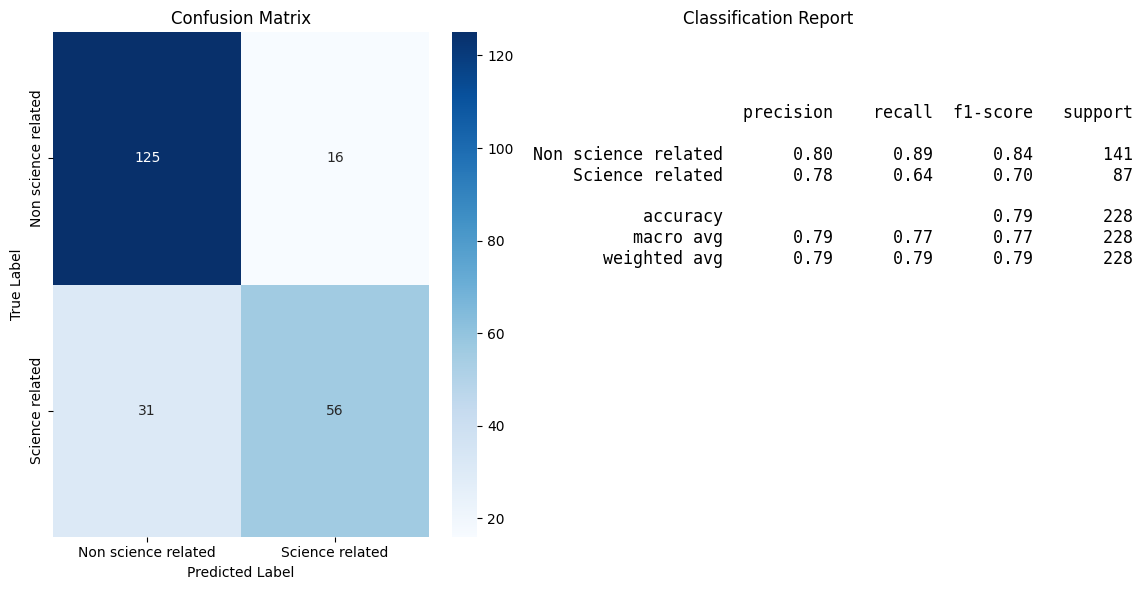

✅ Results saved to: ../results/Step1/NB


In [42]:
model = config.get_model("NB")
classifier = MultinomialNB(alpha=model.get_config("alpha"))
pipeline_NB = get_pipeline(model, classifier, scaler=False)


pipeline_NB.fit(X_train, y_train)
y_pred = pipeline_NB.predict(X_test)

f1_m, f1_std = get_score(pipeline_NB)
fig = display_result(y_pred, y_test)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)


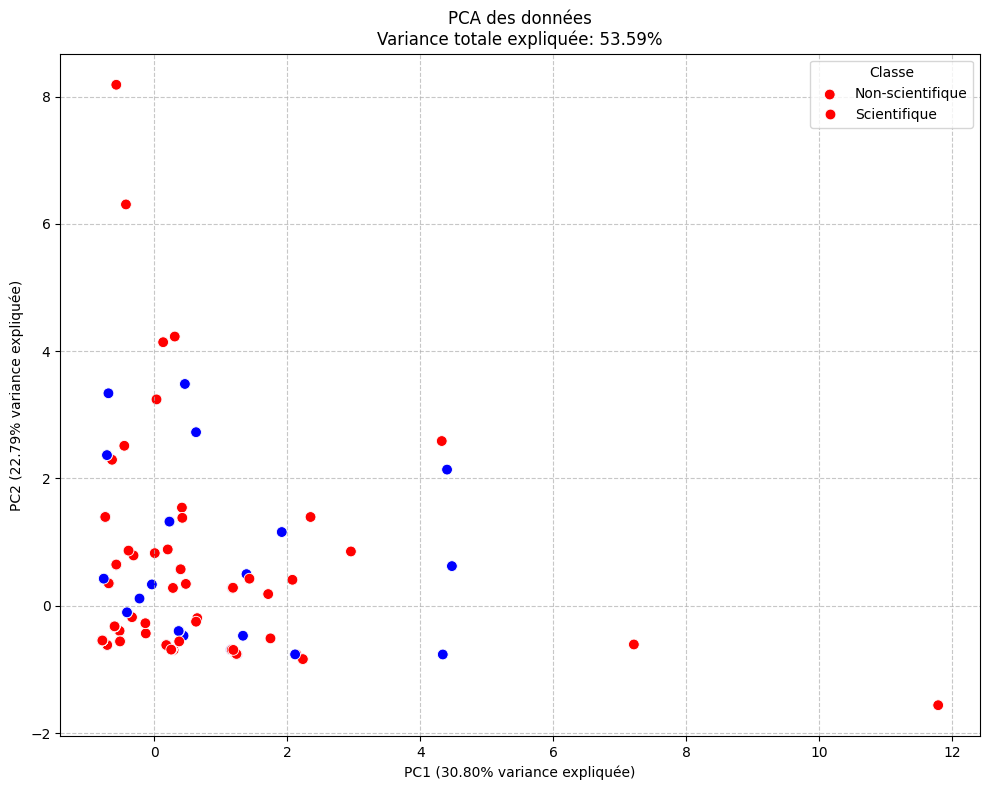

In [24]:
reduced_data = visualize_data_with_pca(X_test, y_test, pipeline_NB)

#### Random Forest avec Bag of words

In [28]:
def objective(trial):
	# Hyperparamètres texte
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Random Forest
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 5, 50)
	min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

	bootstrap = trial.suggest_categorical("bootstrap", [True, False])
	max_features_model = trial.suggest_categorical("max_features_model", ['sqrt', 'log2', None])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)

	classifier = RandomForestClassifier(
		n_estimators=n_estimators,
		max_depth=max_depth,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		random_state=config.random_state,
		max_features= max_features_model,
		bootstrap = bootstrap,
		class_weight='balanced'
	)

	
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 18:57:13,128] A new study created in memory with name: no-name-a48d9e12-c059-474e-9bf7-e1c671b203b8


In [29]:
study.optimize(objective, n_trials=200)
print("✅ Best f1_macro:", study.best_value)
print("✅ Best params:", study.best_params)
config.save_model("RandomForest", study.best_params)

[I 2025-05-06 18:57:28,829] Trial 0 finished with value: 0.6952351713452866 and parameters: {'ngram_range': 'unigram', 'min_df': 6, 'max_features': 18000, 'n_estimators': 300, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features_model': None, 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 0 with value: 0.6952351713452866.
[I 2025-05-06 18:57:33,470] Trial 1 finished with value: 0.7263269079903384 and parameters: {'ngram_range': 'unigram', 'min_df': 5, 'max_features': 6000, 'n_estimators': 800, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features_model': 'sqrt', 'n_keywords': 30, 'vectorizer_type': 'bow'}. Best is trial 1 with value: 0.7263269079903384.
[I 2025-05-06 18:57:34,447] Trial 2 finished with value: 0.759504027648227 and parameters: {'ngram_range': 'unigram', 'min_df': 2, 'max_features': 16000, 'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1,

✅ Best f1_macro: 0.7640428478325827
✅ Best params: {'ngram_range': 'unigram', 'min_df': 2, 'max_features': 11000, 'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features_model': 'log2', 'n_keywords': 10, 'vectorizer_type': 'bow'}
✅  Model (RandomForest) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.818 ± 0.027


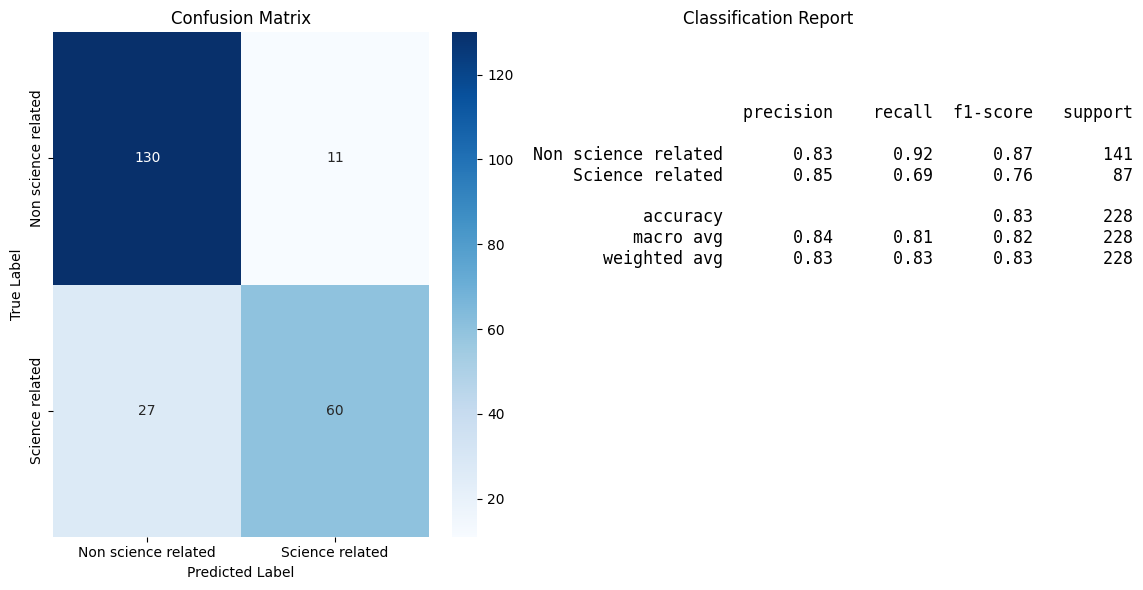

✅ Results saved to: ../results/Step1/RandomForest


In [51]:
model = config.get_model("RandomForest")

classifier = RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		bootstrap = model.get_config("bootstrap"),
		max_features = model.get_config("max_features_model"),
		random_state = config.random_state,
		class_weight='balanced'
	)

pipeline_RF = get_pipeline(model, classifier, scaler=False)

pipeline_RF.fit(X_train, y_train)
y_pred = pipeline_RF.predict(X_test)


f1_m, f1_std = get_score(pipeline_RF)
fig = display_result(y_pred, y_test)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)


#### Regression Logistique avec Bag of Words

In [31]:
def objective(trial):
	
	# Hyperparamètres texte
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-4, 100.0, log=True)
	penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
	solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)

	if penalty == "l1" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()

	if penalty == "l2" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()
	

	classifier = LogisticRegression(
		C=C,
		penalty=penalty,
		solver=solver,
		random_state=config.random_state,
		class_weight='balanced',
		max_iter=8000
	)

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow", "tfidf"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 19:09:21,984] A new study created in memory with name: no-name-849e9b6c-69e8-4814-bfb2-68bf8c2069da


In [32]:
study.optimize(objective, n_trials=50)
print("✅ Best f1_macro:", study.best_value)
print("🏆 Best hyperparameters:", study.best_params)

config.save_model("LogisticRegression", study.best_params)

[I 2025-05-06 19:09:51,002] Trial 0 finished with value: 0.7353157774732103 and parameters: {'ngram_range': 'bigram', 'min_df': 2, 'max_features': 8000, 'C': 32.82348898858274, 'penalty': 'l1', 'solver': 'saga', 'n_keywords': 25, 'vectorizer_type': 'bow'}. Best is trial 0 with value: 0.7353157774732103.
[I 2025-05-06 19:09:51,643] Trial 1 finished with value: 0.6518283866640017 and parameters: {'ngram_range': 'bigram', 'min_df': 3, 'max_features': 10000, 'C': 0.010475176669525656, 'penalty': 'l2', 'solver': 'saga', 'n_keywords': 20, 'vectorizer_type': 'bow'}. Best is trial 0 with value: 0.7353157774732103.
[I 2025-05-06 19:09:53,496] Trial 2 finished with value: 0.7249670317433776 and parameters: {'ngram_range': 'bigram', 'min_df': 5, 'max_features': 19000, 'C': 62.992287787948534, 'penalty': 'l2', 'solver': 'saga', 'n_keywords': 10, 'vectorizer_type': 'tfidf'}. Best is trial 0 with value: 0.7353157774732103.
[I 2025-05-06 19:09:54,709] Trial 3 finished with value: 0.406087202514009 an

✅ Best f1_macro: 0.7657238835801662
🏆 Best hyperparameters: {'ngram_range': 'bigram', 'min_df': 1, 'max_features': 5000, 'C': 5.668605010092585, 'penalty': 'l2', 'solver': 'saga', 'n_keywords': 10, 'vectorizer_type': 'tfidf'}
✅  Model (LogisticRegression) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.791 ± 0.028


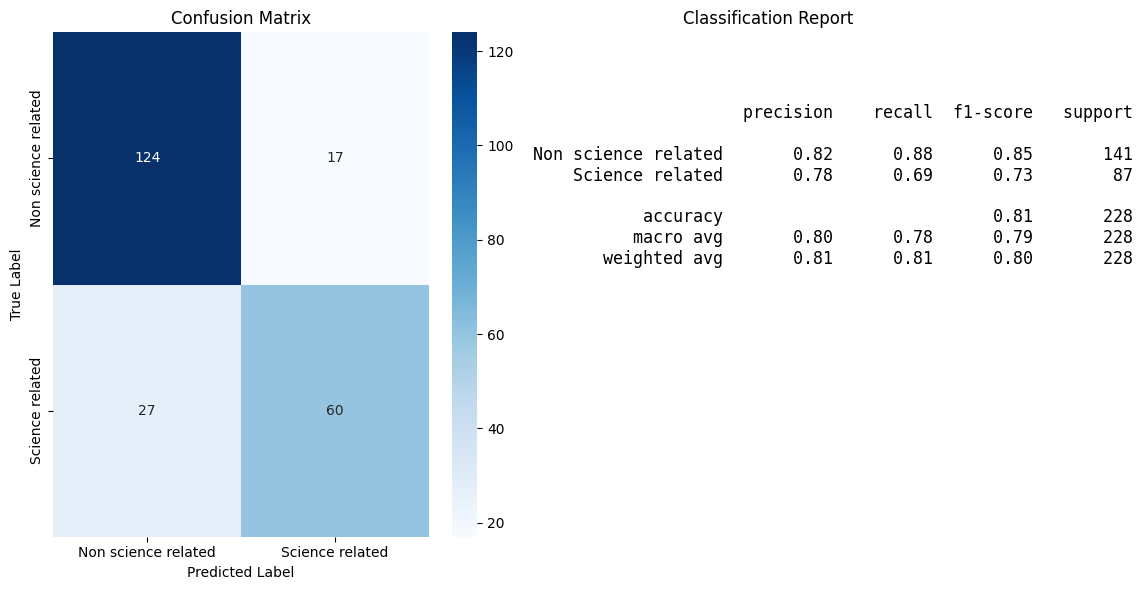

✅ Results saved to: ../results/Step1/LogisticRegression


In [33]:
model = config.get_model("LogisticRegression")
classifier = LogisticRegression(
        C = model.get_config("C"),
            penalty = model.get_config("penalty"),
        solver = model.get_config("solver"),
        class_weight = "balanced",
        random_state = config.random_state,
        max_iter = 8000
    )

pipelineLR = get_pipeline(model, classifier, scaler=True)

pipelineLR.fit(X_train, y_train)
y_pred = pipelineLR.predict(X_test)

f1_m, f1_std = get_score(pipelineLR)
fig = display_result(y_pred, y_test)
save_result(
	title="Rapport du Regression Logistique avec TF-IDF",
	description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
	fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)

#### Linear SVC

In [36]:
from sklearn.svm import LinearSVC

def objective(trial):
	# Hyperparamètres texte
	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-4, 100.0, log=True)
	loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
	dual = trial.suggest_categorical("dual", [True, False])

	if loss == "hinge" and dual is False:
		raise optuna.exceptions.TrialPruned()

	classifier = LinearSVC(
		C=C,
		loss=loss,
		dual=dual,
		random_state=config.random_state,
		max_iter=40_000,
		class_weight="balanced"
	)

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:19:21,902] A new study created in memory with name: no-name-b18b5e2d-f872-4319-ba14-b949af712ca6


In [37]:
study.optimize(objective, n_trials=100)
print("✅ Best f1_macro:", study.best_value)
print("🏆 Best hyperparameters:", study.best_params)

config.save_model("LinearSVC", study.best_params)

[I 2025-05-06 19:19:24,852] Trial 0 pruned. 
[I 2025-05-06 19:19:24,856] Trial 1 pruned. 
[I 2025-05-06 19:19:25,237] Trial 2 finished with value: 0.746613597458263 and parameters: {'n_keywords': 15, 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 8000, 'C': 0.19138555943232416, 'loss': 'squared_hinge', 'dual': False, 'vectorizer_type': 'tfidf'}. Best is trial 2 with value: 0.746613597458263.
[I 2025-05-06 19:19:25,241] Trial 3 pruned. 
[I 2025-05-06 19:19:25,245] Trial 4 pruned. 
[I 2025-05-06 19:19:25,911] Trial 5 finished with value: 0.7243235401037756 and parameters: {'n_keywords': 30, 'ngram_range': 'trigram', 'min_df': 8, 'max_features': 17000, 'C': 28.00968286588837, 'loss': 'squared_hinge', 'dual': False, 'vectorizer_type': 'tfidf'}. Best is trial 2 with value: 0.746613597458263.
[I 2025-05-06 19:19:25,915] Trial 6 pruned. 
[I 2025-05-06 19:19:26,329] Trial 7 finished with value: 0.7079008771395849 and parameters: {'n_keywords': 25, 'ngram_range': 'unigram', 'min_df': 9,

✅ Best f1_macro: 0.7660104657434849
🏆 Best hyperparameters: {'n_keywords': 15, 'ngram_range': 'bigram', 'min_df': 1, 'max_features': 6000, 'C': 0.5410053364325239, 'loss': 'squared_hinge', 'dual': True, 'vectorizer_type': 'tfidf'}
✅  Model (LinearSVC) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.794 ± 0.027


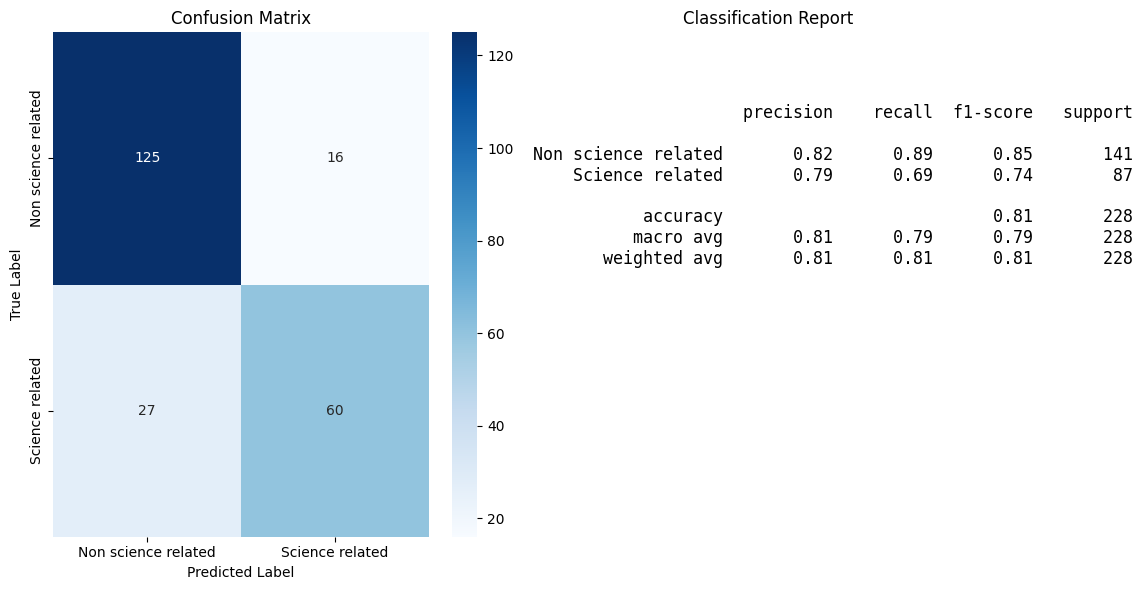

✅ Results saved to: ../results/Step1/LinearSVC


In [38]:
model = config.get_model("LinearSVC")
classifier = LinearSVC(
		C=model.get_config("C"),
		loss=model.get_config("loss"),
		dual=model.get_config("dual"),
		random_state=config.random_state,
		max_iter=40_000,
		class_weight="balanced"
	)

pipeline = get_pipeline(model, classifier, scaler=True)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f1_m, f1_std = get_score(pipeline)

fig = display_result(y_pred, y_test)
save_result(
	title= f"Rapport du {model.name} avec TF-IDF",
	description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
	fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)

## Evaluation des modèles

In [44]:
importances = pipeline_RF.named_steps['classifier'].feature_importances_
features = pipeline_RF.named_steps['preprocessor'].get_feature_names_out()
feature_importances = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances:
	if not feature.startswith("text__"):
		print(f"{feature}: {importance:.4f}")

num__link_count: 0.0286
num__emoji_count: 0.0183
num__mention_count: 0.0082
num__hashtag_count: 0.0029
num__numbers_count: 0.0017


✅ F1-score (bootstrap sur test, 100 itérations): 0.783 ± 0.028


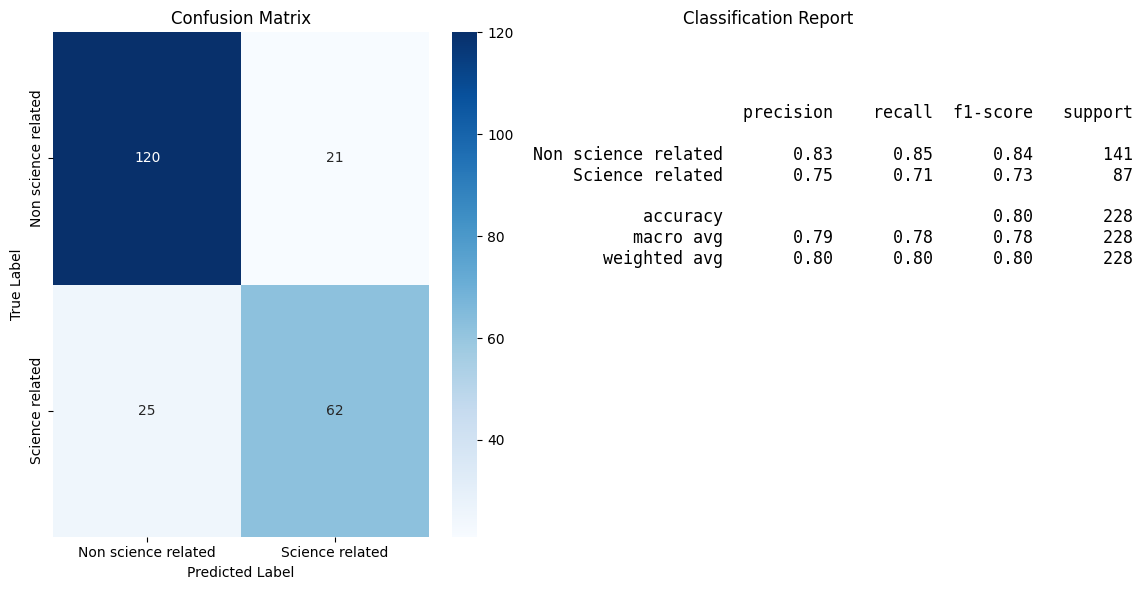

✅ Results saved to: ../results/Step1/RandomForest


In [50]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(pipeline_RF.named_steps['classifier'], threshold='mean')

model = config.get_model("RandomForest")

classifier = RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		bootstrap = model.get_config("bootstrap"),
		max_features = model.get_config("max_features_model"),
		random_state = config.random_state,
		class_weight='balanced'
	)

pipeline_reduit = Pipeline([
    ("preprocessor", pipeline_RF.named_steps["preprocessor"]),
    ("selector", selector),
    ("classifier", classifier)
])

pipeline_reduit.fit(X_train, y_train)
y_pred = pipeline_reduit.predict(X_test)


f1_m, f1_std = get_score(pipeline_reduit)
fig = display_result(y_pred, y_test)

save_result(
	title=f"Rapport du {model.name} (réduit)",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)

En supprimant certaines variables jugées faiblement importantes individuellement, on a peut-être écarté des variables qui, combinées à d'autres, apportaient une complémentarité.

Cela explique les pertes de performance de ce modèle (0.783 ± 0.028) alors que le RandomForest avec les features complémentaire (0.818 ± 0.027).

Notre meilleur modèle est le Random Forest avec TF-IDF.

Il a un score F1 de 0.82 ± 0.027 sur le jeu de test, ce qui est supérieur à tous les autres modèles testés.

Nous avons également utilisé Optuna pour optimiser les hyperparamètres de ce modèle, ce qui a permis d'améliorer ses performances.

Le choix des features a également eu un impact significatif sur les performances du modèle.
Par example, link_count et emoji_count ont été identifiés comme des features importantes par le modèle Random Forest.

# Step 2
Ce notebook va s'interresser a classifier les classes {claim, reference} vs {context} vs {claim, reference, context}

In [37]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.StepConfig = helper.ConfigLoader.load_step2()

In [4]:
df_path= "../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

df_base = df_base[df_base["science_related"] == 1]

classe = {
	(1,0) : 0,
	(0,1) : 1,
	(1,1) : 2,
}

df_base["claim_ref"] = df_base["scientific_claim"].combine_first(df_base["scientific_reference"]).astype(int)
df_base["scientific_context"] = df_base["scientific_context"].astype(int)
df_base["classe"] = df_base.apply(lambda row: classe.get((row["claim_ref"], row["scientific_context"]), None), axis=1)

df_base = df_base.drop(["science_related","scientific_claim","scientific_reference", "scientific_context", "claim_ref"], axis=1)

In [6]:
def dispay_df(df : DataFrame):
	return df.head().style.set_properties(
		subset=['text'],
		**{
			'text-align': 'left',
			'width': '600px',
			'white-space': 'normal'
		}
	)

In [7]:
dispay_df(df_base)

,text,classe
2,Can any Gynecologist with Cancer Experience explain the dangers of Transvaginal Douching with Fluoride or other toxins such as Dioxin? #PDX,0
3,Couch-lock highs lead to sleeping in the couch. Gotta stop doing this shit.,0
4,Does daily routine help prevent problems with bipolar disorder http://t.co/XGUfUDoLJB,0
6,“Traffic Jam” In Brain’s Neurons Could Be Cause Of Statin-Related Cognitive Decline http://t.co/kQ3XPdePKX,2
7,Can playing more games improve lives and save the world? by @chris_pelle via @PostArcade http://t.co/uEtVu099Ad #CDA30,0


## Maintenant on va définir les pre-processings

In [8]:
def word_length(X : DataFrame):
	tokenizer = TweetTokenizer()
	X["word_length"] =  X["text"].apply(lambda x: len(x) / len(tokenizer.tokenize(x)))
	return X

def numbers_processing(X: DataFrame) -> DataFrame:
	X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'\d+(\.\d+)?', 'NUM', x)).astype("string")
	return X

def uppercase_processing(X: DataFrame) -> DataFrame:
	X["uppercase_ratio"] = X["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
	return X

def emoji_processing(X: DataFrame) -> DataFrame:
	def remove_emojis(text):
		return ''.join(char for char in text if char not in emoji.EMOJI_DATA)
	
	X["emoji_presence"] = X["text"].apply(lambda x: any(char in emoji.EMOJI_DATA for char in x)).astype(int)
	X["text"] = X["text"].apply(remove_emojis).astype("string")
	return X

def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', 'url', text)
	
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link).astype("string")
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
	X["hashtag_count"] = X["text"].apply(lambda x: len(re.findall(r'#\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'#(\w+)', r'\1', x)).astype("string")
	return X

def mention_processing(X: DataFrame) -> DataFrame:
	X["mention_count"] = X["text"].apply(lambda x: len(re.findall(r'@\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'@(\w+)', "MENTION", x)).astype("string")
	return X


def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X["text"] = X["text"].apply(preprocess).astype("string")
	return X

In [9]:
df = df_base.copy()

df = word_length(df)
df = numbers_processing(df)
df = uppercase_processing(df)
df = emoji_processing(df)
df = link_processing(df)
df = hashtag_processing(df)
df = mention_processing(df)
df = pre_processing(df)

In [10]:
class KeywordFeatures(BaseEstimator, TransformerMixin):
	def __init__(self, n_keywords=10, verbose=False):
		self.verbose = verbose
		self.keyword_categories = {
			"context": [],
			"claim_ref": []
		}
		self.n_keywords = n_keywords
		self.regex_patterns = {}

	def _extract_category_keywords(self, text, category):
			return [word for word, pattern in self.regex_patterns[category].items() if pattern.search(text)]
	
	def _extract_top_keywords(self, text_series):
		"""
		Extrait les n mots les plus fréquents d'une série de textes.
		Le texte est supposé être déjà lemmatisé.
		"""
		combined_text = " ".join(text_series)
		tokens = re.findall(r'\b\w+\b', combined_text.lower())
		word_counts = Counter(tokens)
		filtered_counts = {word: count for word, count in word_counts.items() if len(word) >= 3}
		
		return [word for word, _ in Counter(filtered_counts).most_common(self.n_keywords * 2)]
	
	def fit(self, X: DataFrame, y:DataFrame):
		context_texts = X.loc[y == 1, 'text'].astype(str)
		claim_ref_texts = X.loc[y == 0, 'text'].astype(str)

		context_keywords = self._extract_top_keywords(context_texts)
		claim_ref_keywords = self._extract_top_keywords(claim_ref_texts)

		# on supprime les mots communs
		common_keywords = set(context_keywords) & set(claim_ref_keywords)
		context_keywords = [word for word in context_keywords if word not in common_keywords]
		claim_ref_keywords = [word for word in claim_ref_keywords if word not in common_keywords]

		self.keyword_categories["context"] = context_keywords[:self.n_keywords]
		self.keyword_categories["claim_ref"] = claim_ref_keywords[:self.n_keywords]

		self.regex_patterns = {
            category: {word: re.compile(r'\b' + word + r'\b', re.IGNORECASE) 
                      for word in words}
            for category, words in self.keyword_categories.items()
        }

		if self.verbose :
			print("Mots-clés science:", self.keyword_categories["science"])
			print("Mots-clés non-science:", self.keyword_categories["non_science"])

		return self

	def transform(self, X: DataFrame):
		X_transformed = X.copy()
		
		for category in self.keyword_categories:
			X_transformed[f"{category}_keyword_count"] = X["text"].apply(
				lambda x: len(self._extract_category_keywords(x, category))
			).astype(int)
		
		return X_transformed
	
	def fit_transform(self, X: DataFrame, y:DataFrame):
		self.fit(X, y)
		return self.transform(X)

In [11]:
X_bin = df.copy()
X_bin = X_bin[X_bin["classe"]  != 2]
y_bin = X_bin.pop("classe")

X_multi_label = df.copy()
y_multi_label = X_multi_label.pop("classe")

## Evaluation des classifiers avec 3 classes {context} vs {claim_ref} vs {both}

ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


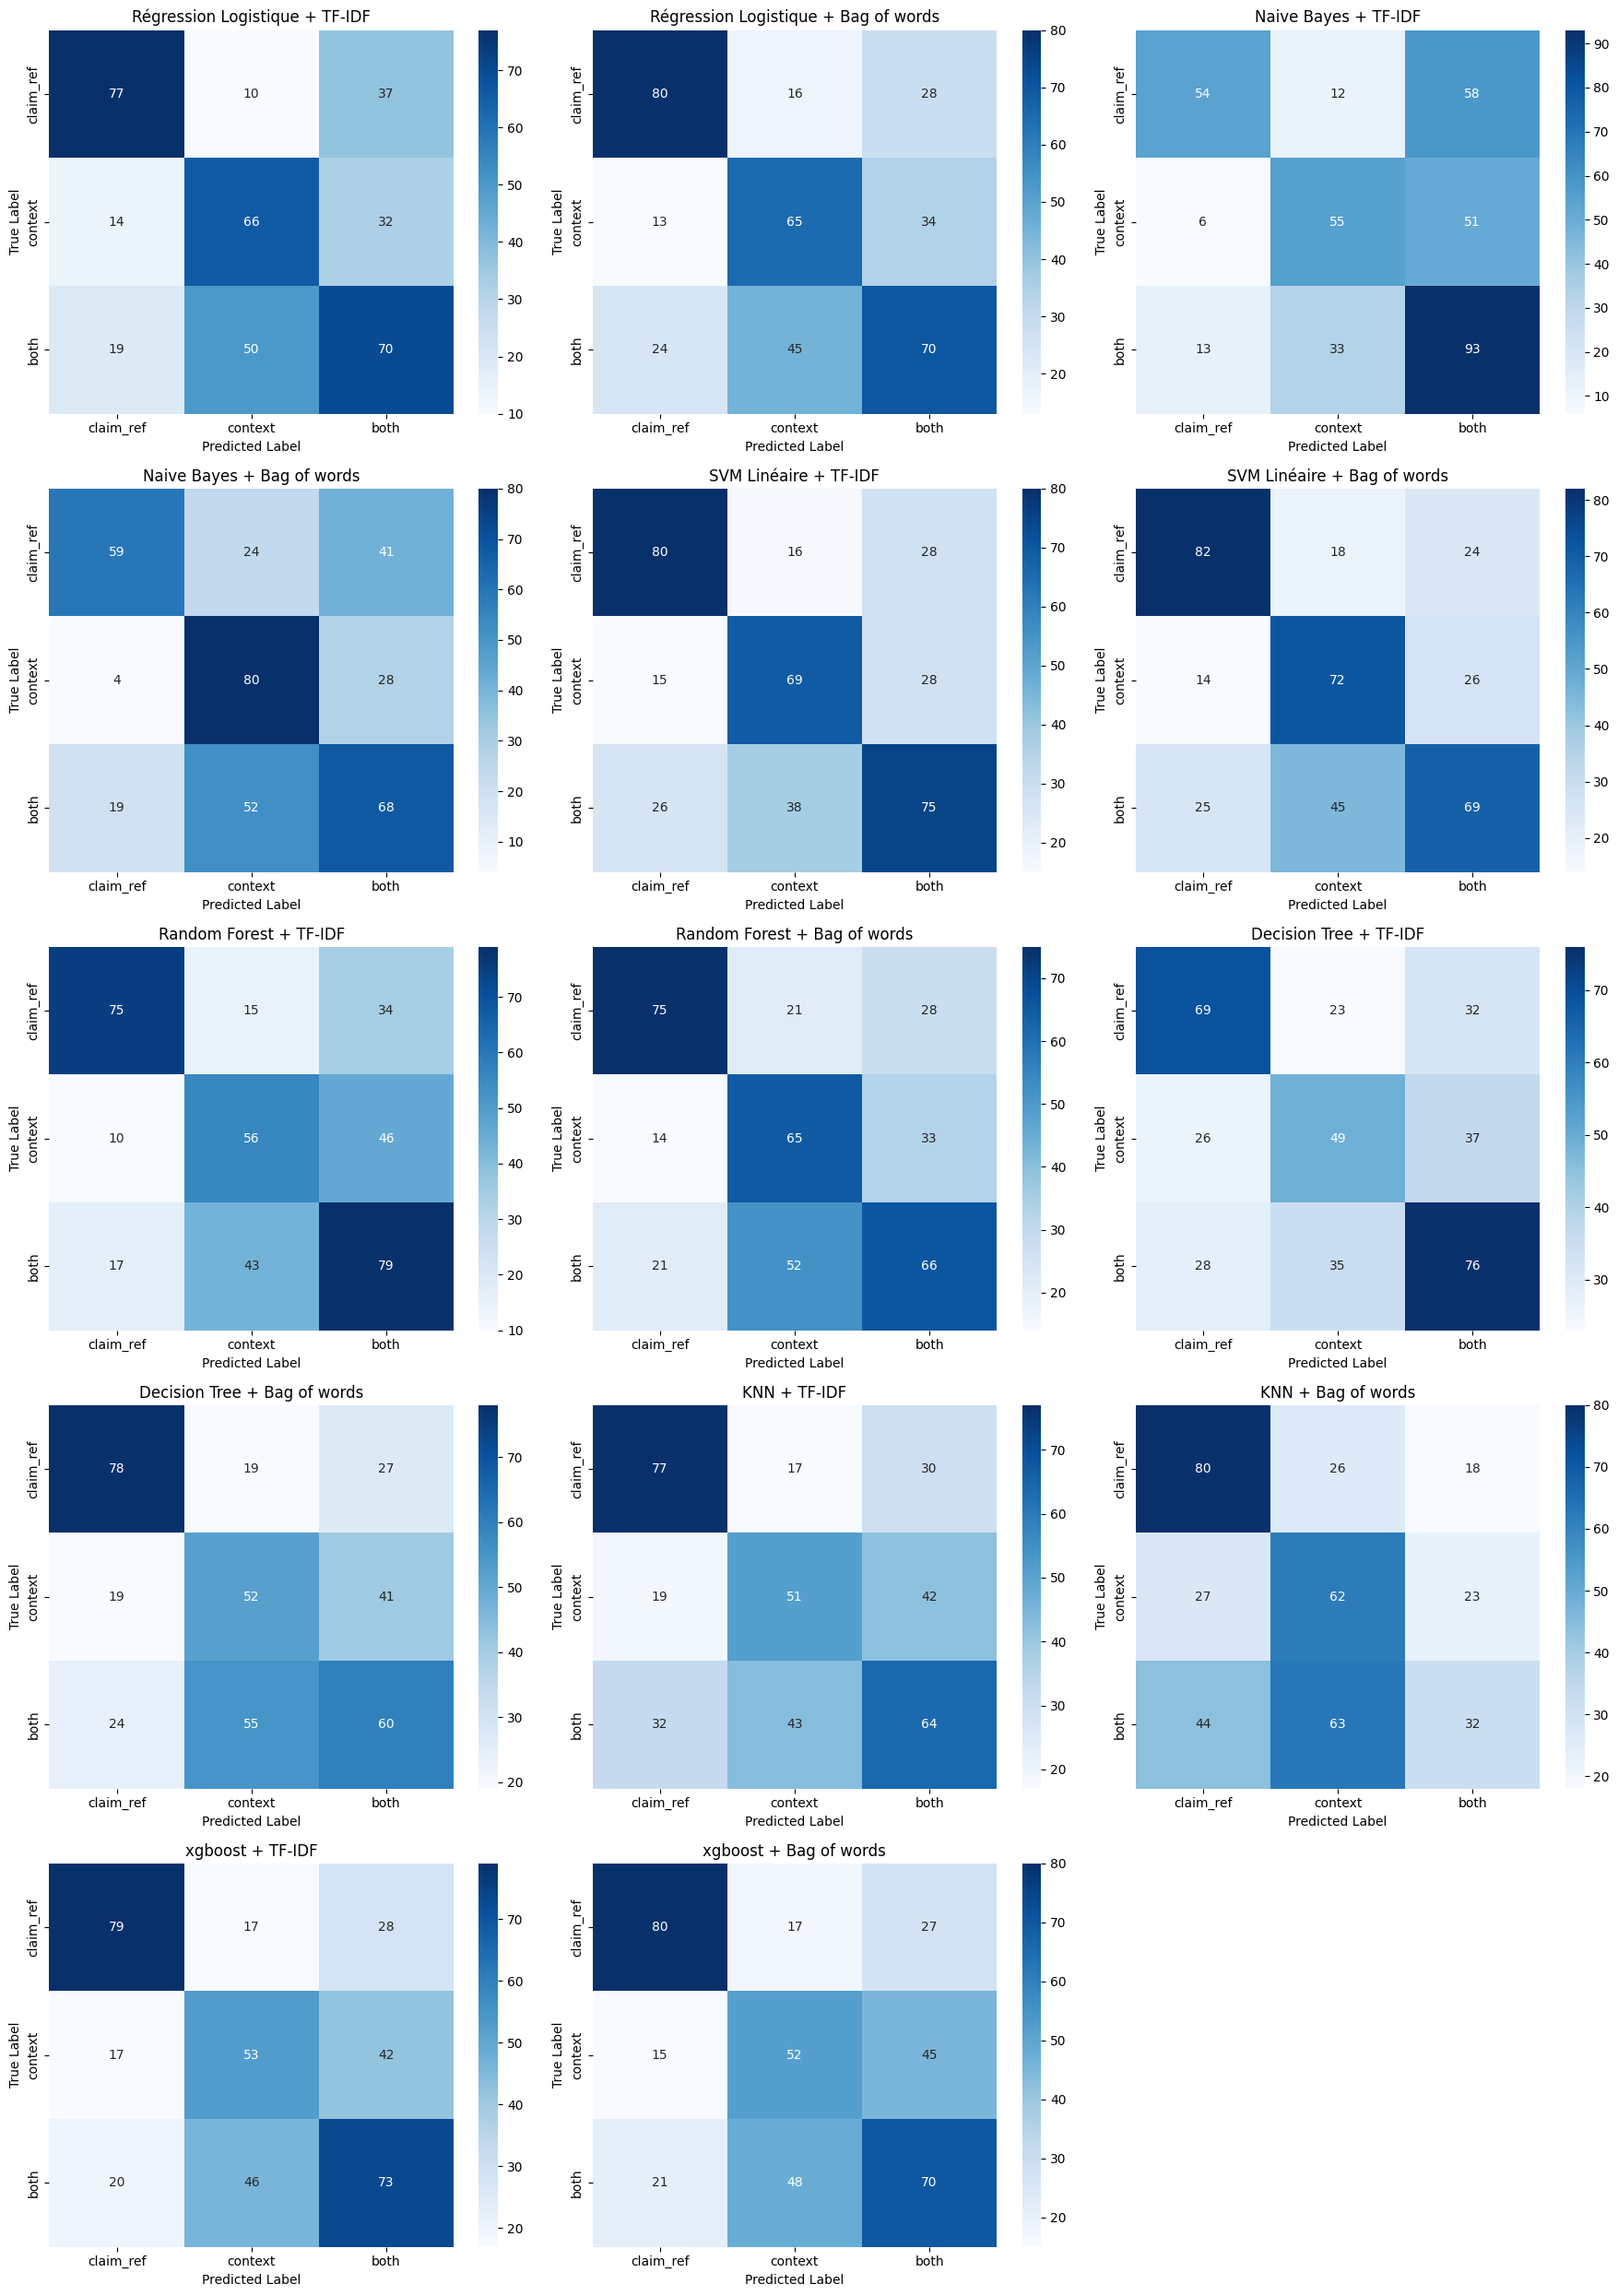

,Classifier,Vectorizer,F1 Mean,F1 Std
4,SVM Linéaire,TF-IDF,0.598,0.050
5,SVM Linéaire,Bag of words,0.594,0.041
1,Régression Logistique,Bag of words,0.573,0.053
0,Régression Logistique,TF-IDF,0.567,0.052
6,Random Forest,TF-IDF,0.562,0.044
3,Naive Bayes,Bag of words,0.551,0.082
7,Random Forest,Bag of words,0.550,0.038
12,xgboost,TF-IDF,0.546,0.055
13,xgboost,Bag of words,0.535,0.053
2,Naive Bayes,TF-IDF,0.531,0.089


In [12]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X_multi_label, y_multi_label, KeywordFeatures(15), config, ["claim_ref", "context", "both"])
results, classement_df = evaluator.evaluate()
classement_df.head(20)

## Evaluation des classifiers avec 2 classes {context} vs {claim_ref}

ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


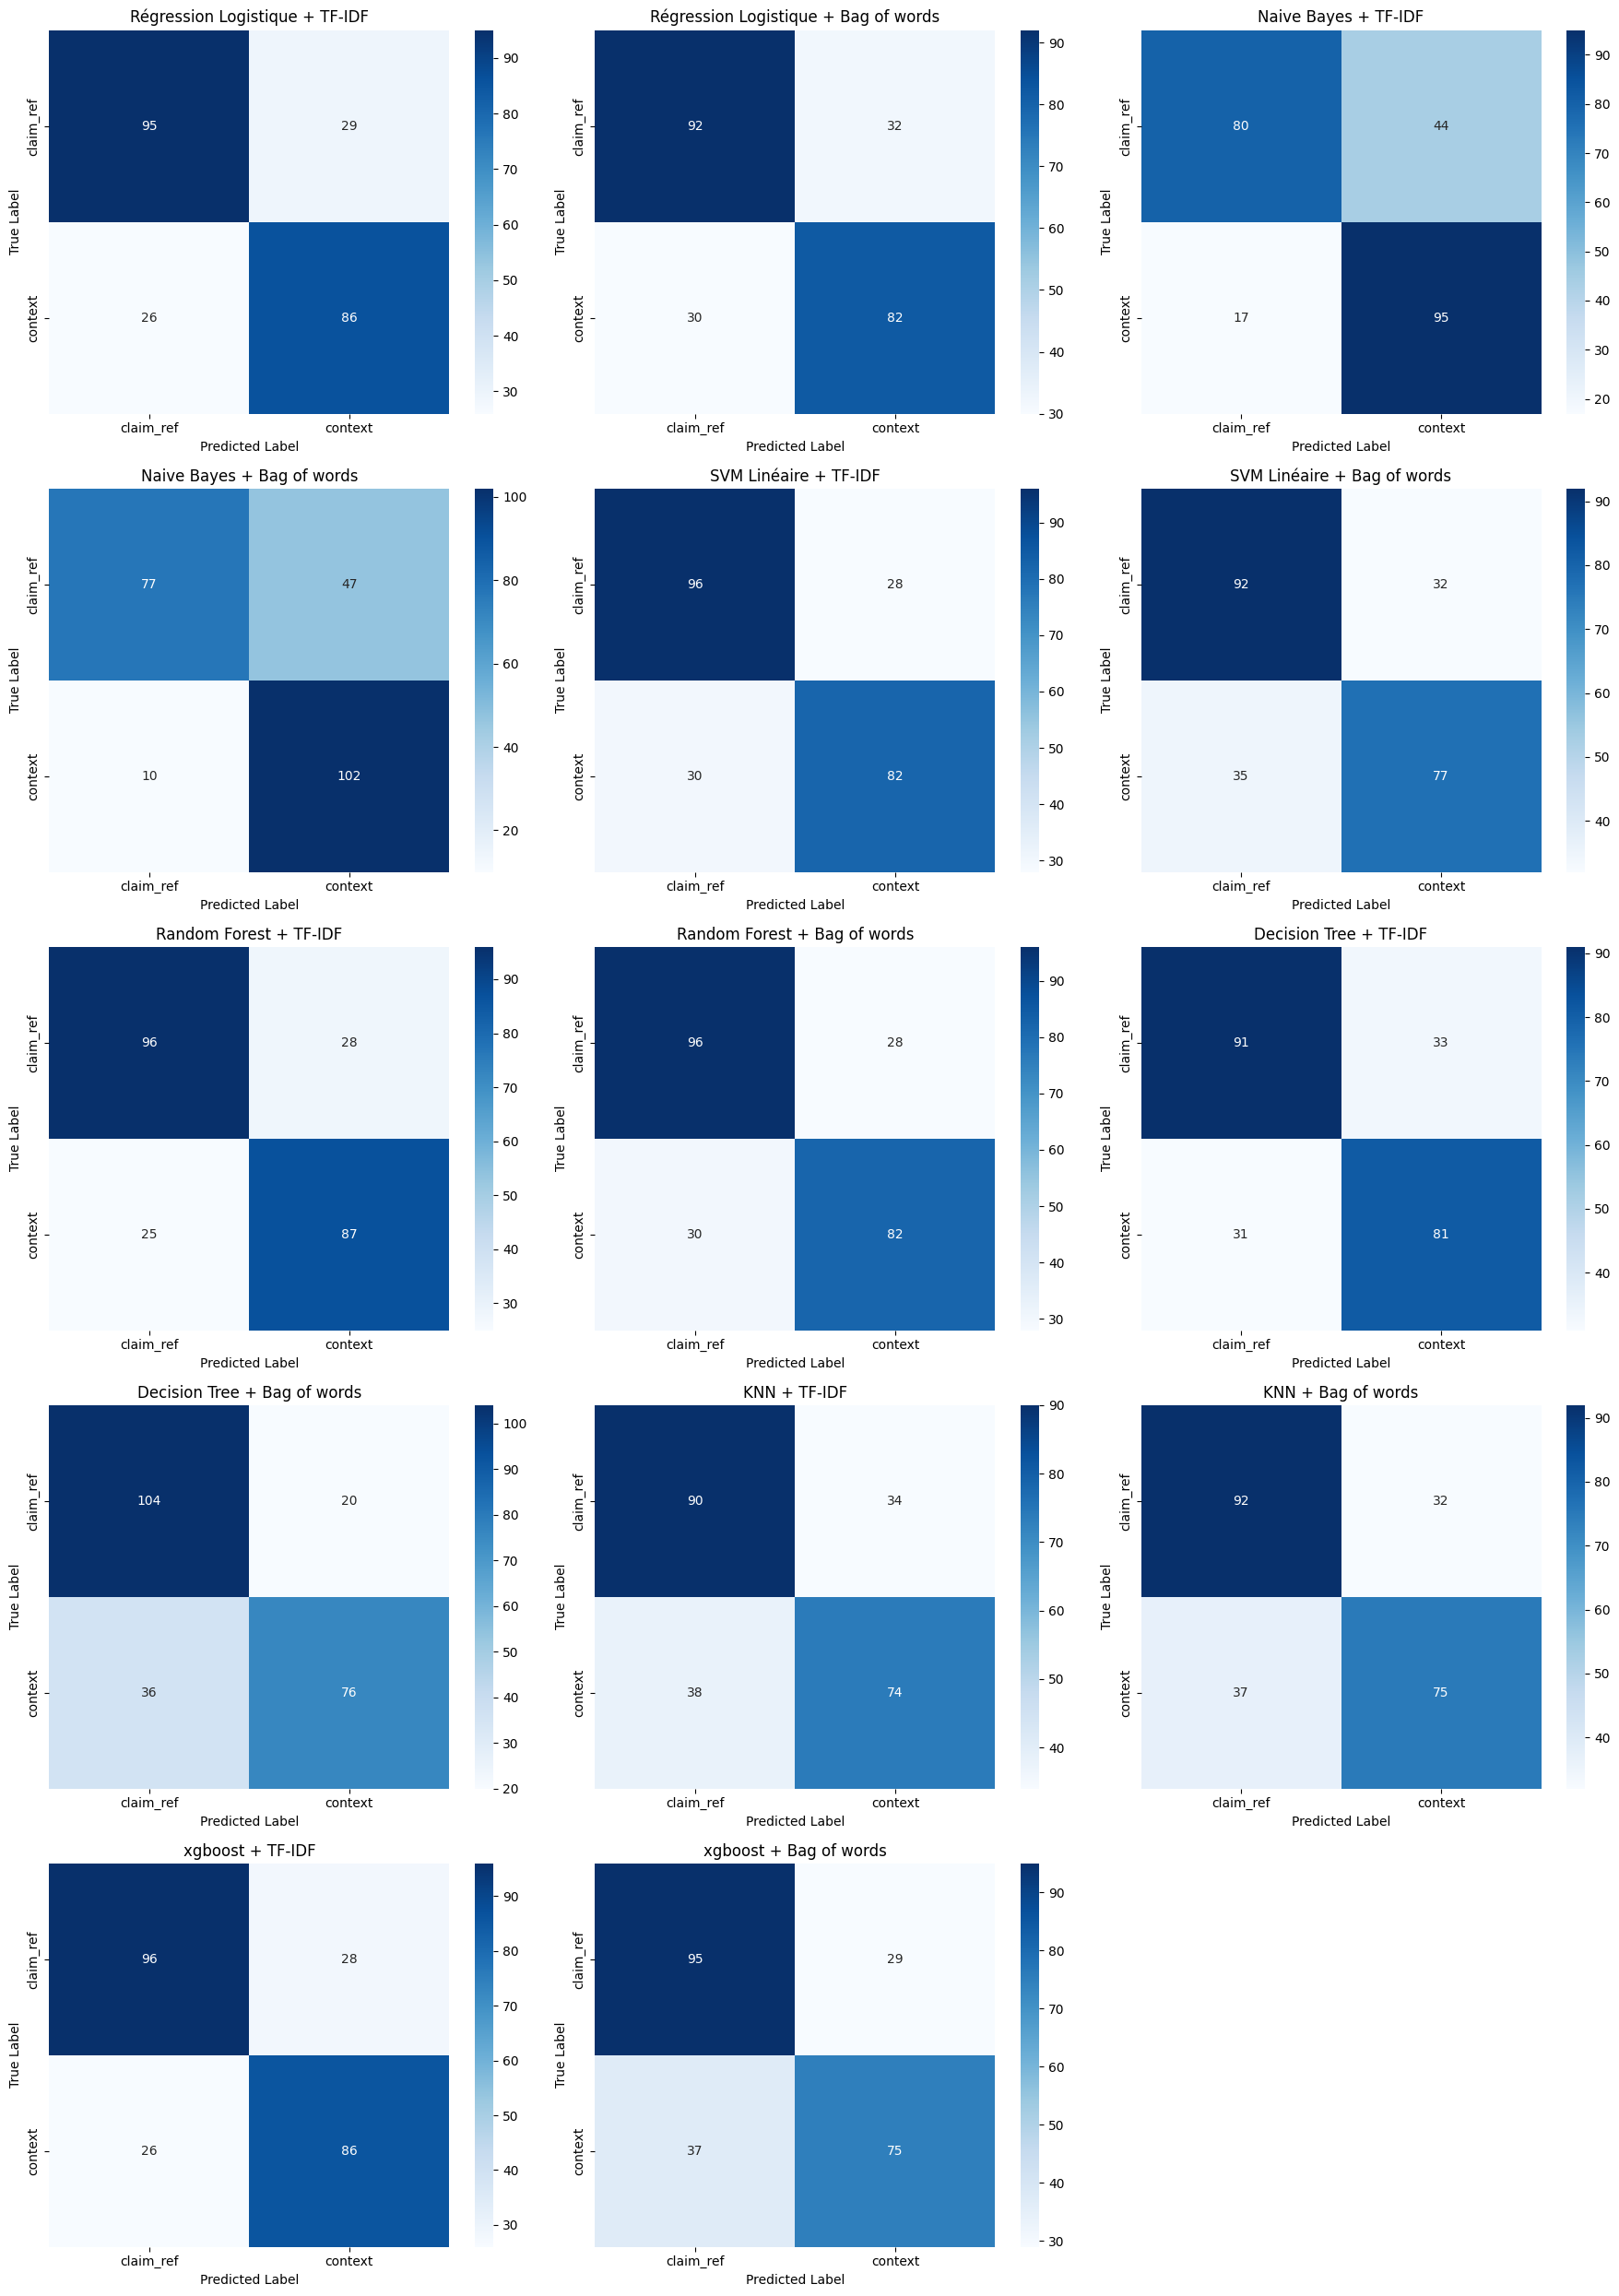

,Classifier,Vectorizer,F1 Mean,F1 Std
6,Random Forest,TF-IDF,0.774,0.036
12,xgboost,TF-IDF,0.768,0.059
0,Régression Logistique,TF-IDF,0.764,0.069
9,Decision Tree,Bag of words,0.757,0.066
3,Naive Bayes,Bag of words,0.753,0.066
7,Random Forest,Bag of words,0.750,0.040
4,SVM Linéaire,TF-IDF,0.748,0.119
2,Naive Bayes,TF-IDF,0.736,0.067
1,Régression Logistique,Bag of words,0.732,0.107
8,Decision Tree,TF-IDF,0.726,0.054


In [ ]:
importlib.reload(evaluation_classifiers)

xticks_label = ["claim_ref", "context"]
evaluator = evaluation_classifiers.ClassifierEvaluation(X_bin, y_bin, KeywordFeatures(15), config, xticks_label)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

## Le choix des modèles et du type de problème (binary ou multi-labels)

### Le choix du type de problème

Comme nous pouvons le voir, les F1-score et leur std sont trés différents selon le type de problème,
C'est baseline nous expose qu'il est plus facile de faire en binaire qu'avec 3 classes

On peut voir que en moyenne nous sommes a 0.74 en binaire alors que nous sommes vers 0.54 avec les 3 classes

je choisis donc la méthode binaire, malgrés que je pers beaucoup de données. 

J'ai aussi choisit de ne pas gardé cette données et l'affecter dans une classe par défault (par example : context), car cela va polluer la classe par le bruit que cela va introduire.

### Le choix de mes Classifiers

1. xgboost & TF-IDF
2. Naive Bayes & TF-IDF
3. Régression Logistique & TF-IDF
4. Random Forest & TF-IDF

Ce choix est en rapport avec le classement, qui me montre clairement les capacités des modèles.

De plus, via mes connaissance personnnels je sais que certains modeles seront nettement plus performant avec de meilleurs hyper paramèttre. (Random Forest)

Je sais que mon dataset n'est pas classifiable linéairement, donc je sais que parmit les 4 modèles certains n'arriveront pas à s'améliorer drastiquement (XBoost, Régression Logistique, Naive Bayes)
Malgrès cela, je suis encore un étudiant, qui est novice, donc je préfère les inclures.

In [14]:
tickslabel = ["claim_ref","context"]
if config.is_multi_label():
	X = X_multi_label
	y = y_multi_label
	tickslabel = ["claim_ref","context", "both"]
	print("==== Classification multi-labels ====")
else:
	X = X_bin
	y = y_bin
	print("==== Classification binaire ====")


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)
X_train.head()

print(f"Nous avons {X_train.shape[0]} tweets d'entrainements et {X_test.shape[0]} de test")

==== Classification binaire ====
Nous avons 188 tweets d'entrainements et 48 de test


In [15]:
ngram_options = {
	"unigram": (1, 1),
	"bigram": (1, 2),
	"trigram": (1, 3),
	"quadrugram": (1, 4)
}
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

text_col = "text"

In [16]:
def visualize_data_with_pca(X_test, y_test, pipeline, title="PCA des données", n_components = 2):
	"""
	Visualise les données transformées avec PCA et colore par classe
	"""
	# 1. Transformer les données avec le préprocesseur du pipeline
	preprocessor = pipeline.named_steps['preprocessor']
	X_transformed = preprocessor.transform(X_test)
	
	# Si la matrice est sparse, la convertir en dense
	if hasattr(X_transformed, "toarray"):
		X_dense = X_transformed.toarray()
	else:
		X_dense = X_transformed
	
	# 2. Appliquer PCA pour réduire à 2 dimensions
	pca = PCA(n_components=n_components)
	X_pca = pca.fit_transform(X_dense)
	
	# 3. Créer un DataFrame pour la visualisation
	df_plot = pd.DataFrame({
		'PC1': X_pca[:, 0],
		'PC2': X_pca[:, 1],
		'Class': y_test.values
	})
	
	# 4. Visualiser avec un scatter plot
	plt.figure(figsize=(10, 8))
	sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Class', 
				   palette={0: "red", 1: "blue"},s=60)
	
	# 5. Ajouter des informations sur la variance expliquée
	explained_var = pca.explained_variance_ratio_
	plt.xlabel(f'PC1 ({explained_var[0]:.2%} variance expliquée)')
	plt.ylabel(f'PC2 ({explained_var[1]:.2%} variance expliquée)')
	plt.title(f'{title}\nVariance totale expliquée: {sum(explained_var):.2%}')
	
	# 6. Ajouter une légende
	plt.legend(title="Classe", labels=["Non-scientifique", "Scientifique"])
	
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.plot()

	return X_pca

from sklearn.utils import resample

def get_score(pipeline, n_iterations=100):
    f1_scores = []
    
    for i in range(n_iterations):
        indices = resample(range(len(X_test)), replace=True, n_samples=len(X_test))
        X_boot = X_test.iloc[indices] if hasattr(X_test, 'iloc') else X_test[indices]
        y_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]

        y_pred = pipeline.predict(X_boot)
        f1 = f1_score(y_boot, y_pred, average='macro')
        f1_scores.append(f1)
    
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    print(f"✅ F1-score (bootstrap sur test, {n_iterations} itérations): {f1_mean:.3f} ± {f1_std:.3f}")
    return f1_mean, f1_std

def get_vectorizer(vectorizer_type, ngram_key, min_df, max_features):
	if vectorizer_type == "tfidf":
		return TfidfVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)
	return CountVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)

def get_trial_score(classifier, vectorizer, n_keywords, scaling = True):
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, "text"),
			("num", StandardScaler() if scaling else "passthrough", numerical_cols)
		]
	)
	
	pipeline = Pipeline([
		("keywords", KeywordFeatures(n_keywords)),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	return  cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()


def get_pipeline(model, classifier, scaler = True):
	vectorizer = model.get_vectorizer()
	numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

	
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, text_col),
			("num", StandardScaler() if scaler else "passthrough", numerical_cols)
		]
	)

	return Pipeline([
		("keywords", KeywordFeatures(model.get_config("n_keywords"))),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

#### XBoost

In [17]:
def objective(trial):
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 3, 10)
	learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
	subsample = trial.suggest_float("subsample", 0.5, 1.0)
	colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
	gamma = trial.suggest_float("gamma", 0, 5)
	reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
	reg_lambda = trial.suggest_float("reg_lambda", 0, 10)
	
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	
	classifier = XGBClassifier(
			n_estimators=n_estimators,
			max_depth=max_depth,
			learning_rate=learning_rate,
			subsample=subsample,
			colsample_bytree=colsample_bytree,
			gamma=gamma,
			reg_alpha=reg_alpha,
			reg_lambda=reg_lambda,
			eval_metric="logloss",
			random_state=config.random_state
		)
	
	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:42:35,821] A new study created in memory with name: no-name-062da50e-74af-4329-bf2e-bfb1de8bab5a


In [18]:
study.optimize(objective, n_trials=100)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("XBoost", study.best_params)

[I 2025-05-06 19:42:39,259] Trial 0 finished with value: 0.6985395830223416 and parameters: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.08947952299741382, 'subsample': 0.9170401408828386, 'colsample_bytree': 0.8630895320350798, 'gamma': 0.2803179918170007, 'reg_alpha': 4.77624627668567, 'reg_lambda': 0.40744915162686524, 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 5, 'max_features': 10000, 'n_keywords': 25}. Best is trial 0 with value: 0.6985395830223416.
[I 2025-05-06 19:42:40,189] Trial 1 finished with value: 0.6730544881295034 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.038747977892762624, 'subsample': 0.8388855646050657, 'colsample_bytree': 0.5251616151865803, 'gamma': 2.978335607623088, 'reg_alpha': 3.5879458100177883, 'reg_lambda': 2.8598681033975715, 'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 9, 'max_features': 15000, 'n_keywords': 10}. Best is trial 0 with value: 0.6985395830223416.
[I 2025-05-06

Best f1_macro: 0.7475583932890272
Best params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.16337785390832182, 'subsample': 0.9470410584430072, 'colsample_bytree': 0.9790991722836205, 'gamma': 0.6426327231855744, 'reg_alpha': 0.6360504191787868, 'reg_lambda': 3.827988954997142, 'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 4, 'max_features': 16000, 'n_keywords': 25}
✅  Model (XBoost) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.683 ± 0.070


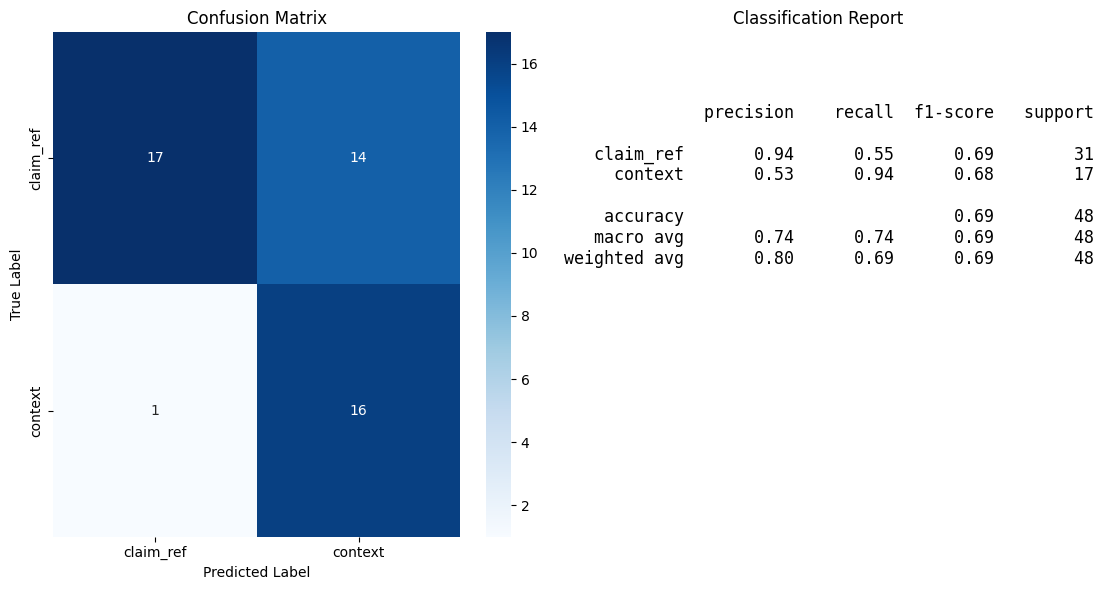

✅ Results saved to: ../results/Step2/Binary/XBoost


In [44]:
model = config.get_model("XBoost")
classifier = XGBClassifier(
			n_estimators= model.get_config("n_estimators"),
			max_depth= model.get_config("max_depth"),
			learning_rate= model.get_config("learning_rate"),
			subsample= model.get_config("subsample"),
			colsample_bytree= model.get_config("colsample_bytree"),
			gamma= model.get_config("gamma"),
			reg_alpha= model.get_config("reg_alpha"),
			reg_lambda= model.get_config("reg_lambda"),
			eval_metric="logloss",
			random_state=config.random_state
		)

pipeline_XBoost = get_pipeline(model, classifier, scaler=False)

pipeline_XBoost.fit(X_train, y_train)
y_pred = pipeline_XBoost.predict(X_test)

f1_m, f1_std = get_score(pipeline_XBoost)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)

#### Naive Bayes

In [20]:
def objective(trial):
	alpha = trial.suggest_float("alpha", 1e-3, 2.0, log=True)

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	
	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(MultinomialNB(alpha=alpha), vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:45:19,346] A new study created in memory with name: no-name-72d73bd0-573e-43b6-b618-88b86971e016


In [22]:
study.optimize(objective, n_trials=50)
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("NB", study.best_params)

[I 2025-05-06 19:45:42,113] Trial 50 finished with value: 0.7625487426005114 and parameters: {'alpha': 0.4484431652529053, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 4, 'max_features': 8000, 'n_keywords': 15}. Best is trial 43 with value: 0.7911214792287931.
[I 2025-05-06 19:45:42,363] Trial 51 finished with value: 0.7858544754738862 and parameters: {'alpha': 0.10787683763737509, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 4, 'max_features': 10000, 'n_keywords': 25}. Best is trial 43 with value: 0.7911214792287931.
[I 2025-05-06 19:45:42,604] Trial 52 finished with value: 0.7539906657690302 and parameters: {'alpha': 0.0010847812612802214, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 3, 'max_features': 6000, 'n_keywords': 30}. Best is trial 43 with value: 0.7911214792287931.
[I 2025-05-06 19:45:42,847] Trial 53 finished with value: 0.7911214792287931 and parameters: {'alpha': 0.15802865331463717, 'vectorizer_type': 'bow', 'ngram_rang

Best f1_macro: 0.7911214792287931
Best params: {'alpha': 0.17693559340924833, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 4, 'max_features': 6000, 'n_keywords': 20}
✅  Model (NB) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.720 ± 0.075


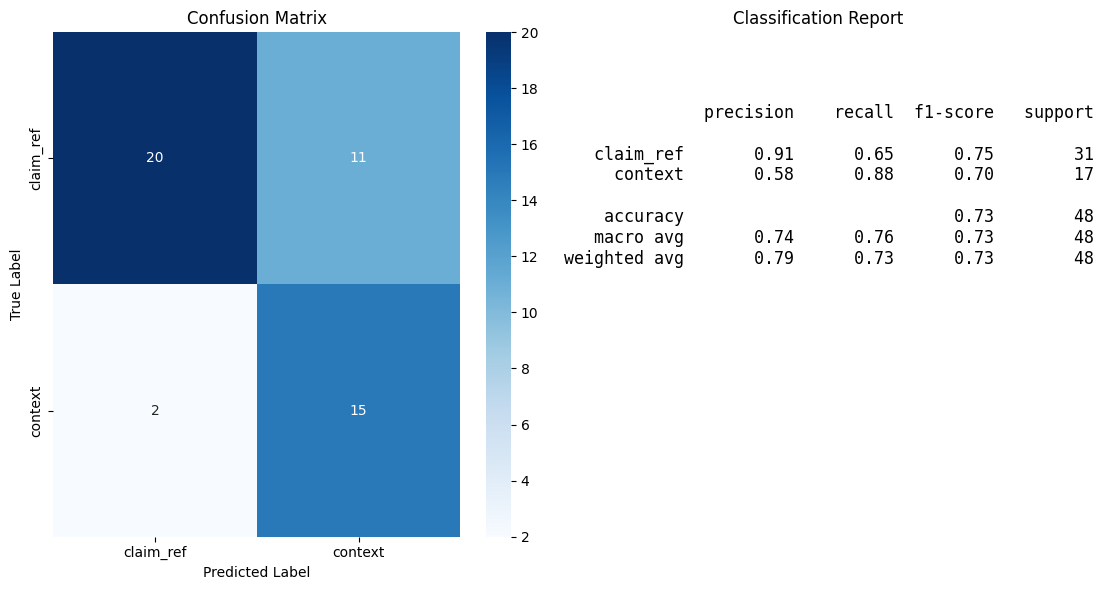

✅ Results saved to: ../results/Step2/Binary/NB


In [43]:
model = config.get_model("NB")
classifier = MultinomialNB(alpha = model.get_config("alpha"))

pipeline_NB = get_pipeline(model, classifier, scaler=False)

pipeline_NB.fit(X_train, y_train)
y_pred = pipeline_NB.predict(X_test)

f1_m, f1_std = get_score(pipeline_NB)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)

#### Régression Logistique

In [25]:
def objective(trial):
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 0, 30, step=5)
	
	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-4, 100.0, log=True)
	penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
	solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

	if penalty == "l1" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()

	if penalty == "l2" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()
	

	classifier = LogisticRegression(
		C=C,
		penalty=penalty,
		solver=solver,
		random_state=config.random_state,
		class_weight='balanced',
		max_iter=8000
	)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:47:13,799] A new study created in memory with name: no-name-a495e0dd-6234-4efe-a358-8a083f94e474


In [28]:
study.optimize(objective, n_trials=50)
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("Regression Logistique", study.best_params)

[I 2025-05-06 19:48:56,866] Trial 100 finished with value: 0.8057098765432098 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 1, 'max_features': 20000, 'n_keywords': 25, 'C': 9.767956380409927, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 84 with value: 0.817795462034621.
/mnt/c/Users/steve/Desktop/ML/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-05-06 19:48:59,297] Trial 101 finished with value: 0.7774136949343721 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 1, 'max_features': 20000, 'n_keywords': 25, 'C': 11.440414220239397, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 84 with value: 0.817795462034621.
[I 2025-05-06 19:48:59,532] Trial 102 finished with value: 0.7949074074074073 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 1, 'max_features

Best f1_macro: 0.823240806477303
Best params: {'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 2, 'max_features': 13000, 'n_keywords': 0, 'C': 70.73605883987985, 'penalty': 'l1', 'solver': 'liblinear'}
✅  Model (Regression Logistique) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.766 ± 0.060


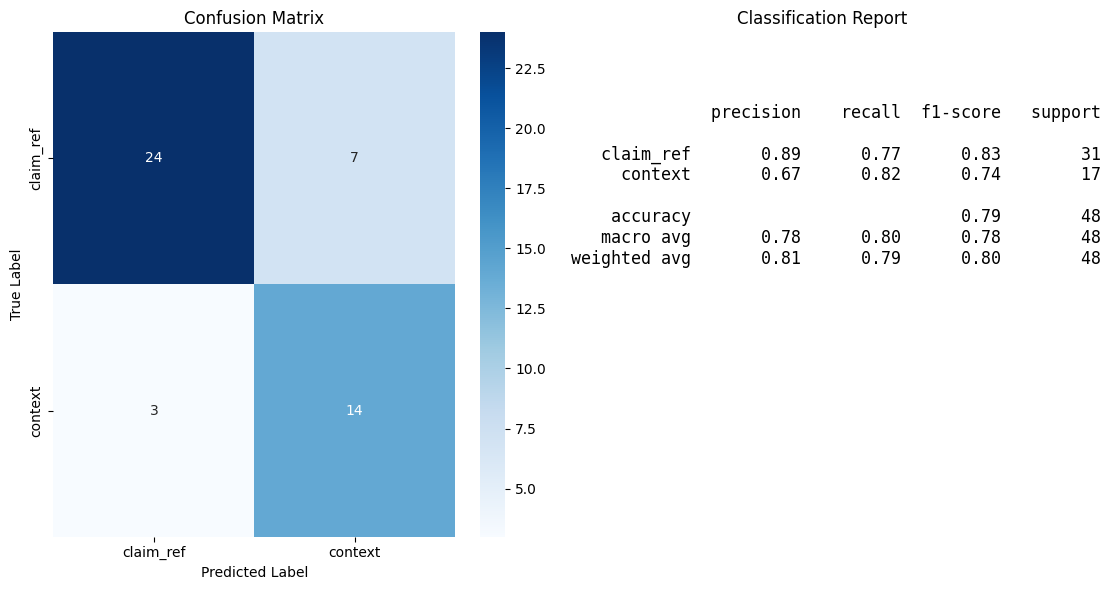

✅ Results saved to: ../results/Step2/Binary/Regression Logistique


In [42]:
model = config.get_model("Regression Logistique")
classifier = LogisticRegression(
        C = model.get_config("C"),
		penalty = model.get_config("penalty"),
        solver = model.get_config("solver"),
        class_weight = "balanced",
        random_state = config.random_state,
        max_iter = 8000
    )

pipeline_RL = get_pipeline(model, classifier)

pipeline_RL.fit(X_train, y_train)
y_pred = pipeline_RL.predict(X_test)

f1_m, f1_std = get_score(pipeline_RL)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)

#### Random Forest

In [32]:
def objective(trial):

	# Hyperparamètres texte
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Random Forest
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 5, 50)
	min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

	bootstrap = trial.suggest_categorical("bootstrap", [True, False])
	max_features_model = trial.suggest_categorical("max_features_model", ['sqrt', 'log2', None])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)


	classifier = RandomForestClassifier(
		n_estimators=n_estimators,
		max_depth=max_depth,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		random_state=config.random_state,
		max_features= max_features_model,
		bootstrap = bootstrap,
		class_weight='balanced'
	)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 19:51:47,792] A new study created in memory with name: no-name-476b41d0-9b00-4bcb-951f-1bc9ad673d93


In [33]:
study.optimize(objective, n_trials=100)
print("✅ Best f1_macro:", study.best_value)
print("✅ Best params:", study.best_params)
config.save_model("RandomForest", study.best_params)

[I 2025-05-06 19:52:00,676] Trial 0 finished with value: 0.7654875980389934 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 19000, 'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features_model': None, 'n_keywords': 10}. Best is trial 0 with value: 0.7654875980389934.
[I 2025-05-06 19:52:02,550] Trial 1 finished with value: 0.785426577420405 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 6, 'max_features': 5000, 'n_estimators': 500, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features_model': 'sqrt', 'n_keywords': 10}. Best is trial 1 with value: 0.785426577420405.
[I 2025-05-06 19:52:12,360] Trial 2 finished with value: 0.7472612116947093 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'quadrugram', 'min_df': 1, 'max_features': 1000, 'n_estimators': 1000, 'max_depth': 10, 'min_samples

✅ Best f1_macro: 0.7956192751891678
✅ Best params: {'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 6, 'max_features': 8000, 'n_estimators': 800, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features_model': 'sqrt', 'n_keywords': 10}
✅  Model (RandomForest) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.741 ± 0.075


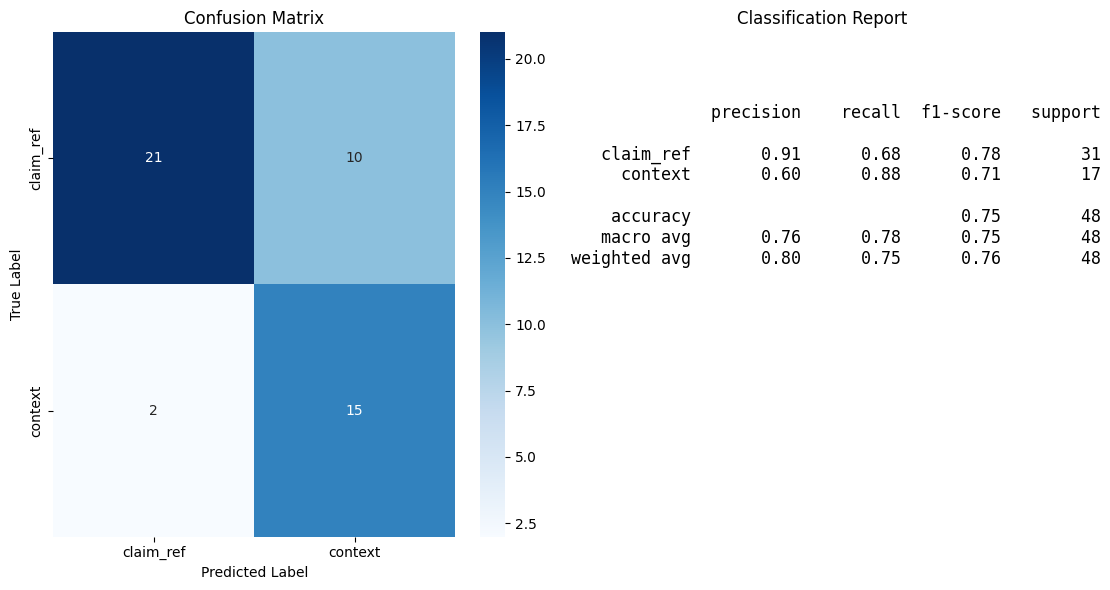

✅ Results saved to: ../results/Step2/Binary/RandomForest


In [45]:
model = config.get_model("RandomForest")
classifier = RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		bootstrap = model.get_config("bootstrap"),
		max_features = model.get_config("max_features_model"),
		random_state = config.random_state,
		class_weight='balanced'
	)

pipeline_RF = get_pipeline(model, classifier, scaler=False)

pipeline_RF.fit(X_train, y_train)
y_pred = pipeline_RF.predict(X_test)

f1_m, f1_std = get_score(pipeline_RF)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)

# STEP 3

In [2]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.StepConfig = helper.ConfigLoader.load_step3()

In [3]:
df_path= "../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

df_base = df_base[df_base["science_related"] == 1]

classe_map = {
	(1, 0, 0): 0,  # Claim only
	(0, 0, 1): 1,  # Context only
	(1, 0, 1): 2,  # Claim + Context
	(0, 1, 1): 3,  # Ref + Context
	(1, 1, 1): 4,  # Claim + Ref + Context
}
x_ticks = ["Claim", "Context", "Claim + Context", "Ref + Context", "Claim + Ref + Context"]

df_base["scientific_claim"] = df_base["scientific_claim"].astype(int)
df_base["scientific_reference"] = df_base["scientific_reference"].astype(int)
df_base["scientific_context"] = df_base["scientific_context"].astype(int)

df_base["classe"] = df_base.apply(
	lambda row: classe_map.get((
		row["scientific_claim"],
		row["scientific_reference"],
		row["scientific_context"]
	), None),
	axis=1
)

df_base.drop(columns=["science_related", "scientific_claim", "scientific_reference", "scientific_context"], inplace=True)


In [4]:
def dispay_df(df : DataFrame):
	return df.head().style.set_properties(
		subset=['text'],
		**{
			'text-align': 'left',
			'width': '600px',
			'white-space': 'normal'
		}
	)

## Maintenant on va définir les pre-processings

In [5]:
def word_length(X : DataFrame):
	tokenizer = TweetTokenizer()
	X["text_length_words"] =  X["text"].apply(lambda x: len(tokenizer.tokenize(x)))
	X["text_length_char"] =  X["text"].apply(len)
	X["word_length"] =  X["text_length_char"] / X["text_length_words"]
	return X

def numbers_processing(X: DataFrame) -> DataFrame:
	X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'\d+(\.\d+)?', 'NUM', x)).astype("string")
	return X

def uppercase_processing(X: DataFrame) -> DataFrame:
	def count_all_uppercase_words(text):
		words = text.split()
		return sum(1 for word in words if word.isupper() and word.isalpha())
	X["uppercase_ratio"] = X["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
	X["uppercase_words_count"] = X["text"].apply(count_all_uppercase_words)
	return X

def emoji_processing(X: DataFrame) -> DataFrame:
	def remove_emojis(text):
		return ''.join(char for char in text if char not in emoji.EMOJI_DATA)
	
	X["emoji_presence"] = X["text"].apply(lambda x: any(char in emoji.EMOJI_DATA for char in x)).astype(int)
	X["text"] = X["text"].apply(remove_emojis).astype("string")
	return X

def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', 'url', text)
	
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link).astype("string")
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
	X["hashtag_count"] = X["text"].apply(lambda x: len(re.findall(r'#\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'#(\w+)', r'\1', x)).astype("string")
	return X

def mention_processing(X: DataFrame) -> DataFrame:
	X["mention_count"] = X["text"].apply(lambda x: len(re.findall(r'@\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'@(\w+)', "MENTION", x)).astype("string")
	return X


def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X["text"] = X["text"].apply(preprocess).astype("string")
	return X

In [6]:
df = df_base.copy()

df = word_length(df)
df = numbers_processing(df)
df = uppercase_processing(df)
df = emoji_processing(df)
df = link_processing(df)
df = hashtag_processing(df)
df = mention_processing(df)
df = pre_processing(df)

In [7]:
class KeywordFeatures(BaseEstimator, TransformerMixin):
	def __init__(self, n_keywords=10, verbose=False):
		self.verbose = verbose
		self.keyword_categories = {}
		self.n_keywords = n_keywords
		self.regex_patterns = {}

	def _extract_category_keywords(self, text, category):
			return [word for word, pattern in self.regex_patterns[category].items() if pattern.search(text)]
	
	def _extract_top_keywords(self, text_series):
		"""
		Extrait les n mots les plus fréquents d'une série de textes.
		Le texte est supposé être déjà lemmatisé.
		"""
		combined_text = " ".join(text_series)
		tokens = re.findall(r'\b\w+\b', combined_text.lower())
		word_counts = Counter(tokens)
		filtered_counts = {word: count for word, count in word_counts.items() if len(word) >= 3}
		
		return [word for word, _ in Counter(filtered_counts).most_common(self.n_keywords * 2)]
	
	def fit(self, X: DataFrame, y:DataFrame):

		claim_texts = X.loc[y == 0, 'text'].astype(str)
		context_texts = X.loc[y == 1, 'text'].astype(str)
		claim_context_texts = X.loc[y == 2, 'text'].astype(str)
		ref_context_texts = X.loc[y == 3, 'text'].astype(str)
		claim_ref_context_texts = X.loc[y == 4, 'text'].astype(str)

		claim_keywords =self._extract_top_keywords(claim_texts)
		context_keywords =self._extract_top_keywords(context_texts)
		claim_context_keywords =self._extract_top_keywords(claim_context_texts)
		ref_context_keywords =self._extract_top_keywords(ref_context_texts)
		claim_ref_context_keywords =self._extract_top_keywords(claim_ref_context_texts)

		self.keyword_categories["Claim"] = claim_keywords[:self.n_keywords]
		self.keyword_categories["Context"] = context_keywords[:self.n_keywords]
		self.keyword_categories["Claim + Context"] = claim_context_keywords[:self.n_keywords]
		self.keyword_categories["Ref + Context"] = ref_context_keywords[:self.n_keywords]
		self.keyword_categories["Claim + Ref + Context"] = claim_ref_context_keywords[:self.n_keywords]

		self.regex_patterns = {
            category: {word: re.compile(r'\b' + word + r'\b', re.IGNORECASE) 
                      for word in words}
            for category, words in self.keyword_categories.items()
        }

		if self.verbose :
			print("Mots-clés science:", self.keyword_categories["science"])
			print("Mots-clés non-science:", self.keyword_categories["non_science"])

		return self

	def transform(self, X: DataFrame):
		X_transformed = X.copy()
		
		for category in self.keyword_categories:
			X_transformed[f"{category}_keyword_count"] = X["text"].apply(
				lambda x: len(self._extract_category_keywords(x, category))
			).astype(int)
		
		return X_transformed
	
	def fit_transform(self, X: DataFrame, y:DataFrame):
		self.fit(X, y)
		return self.transform(X)

### On va maintenant trouver un classifiers (baseline) 

In [8]:
X = df.copy()
y = X.pop("classe")

dispay_df(X)

,text,text_length_words,text_length_char,word_length,numbers_count,uppercase_ratio,uppercase_words_count,emoji_presence,link_count,hashtag_count,mention_count
2,gynecologist cancer experience explain danger transvaginal douching fluoride toxin dioxin pdx,22,139,6.318182,0,0.079137,0,0,0,1,0
3,couch lock high lead sleep couch get to stop shit,15,75,5.000000,0,0.026667,0,0,0,0,0
4,daily routine help prevent problem bipolar disorder url,10,85,8.500000,0,0.105882,0,0,1,0,0
6,traffic jam brain neuron cause statin relate cognitive decline url,17,106,6.235294,1,0.203704,0,0,1,0,0
7,play game improve life save world mention mention url cdanum,17,118,6.941176,2,0.126050,0,0,1,1,2


## Evaluation des classifiers avec des multi-labels

In [11]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X, y, KeywordFeatures(15), config, x_ticks, verbose= False)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

,Classifier,Vectorizer,F1 Mean,F1 Std
8,Decision Tree,TF-IDF,0.412,0.040
9,Decision Tree,Bag of words,0.412,0.064
1,Régression Logistique,Bag of words,0.395,0.081
4,SVM Linéaire,TF-IDF,0.393,0.072
0,Régression Logistique,TF-IDF,0.375,0.080
5,SVM Linéaire,Bag of words,0.373,0.047
7,Random Forest,Bag of words,0.351,0.023
12,xgboost,TF-IDF,0.347,0.024
6,Random Forest,TF-IDF,0.334,0.042
13,xgboost,Bag of words,0.325,0.015


Au vu des résultats, nous pouvons nous sentir seul et isoler, surtout que bibou m'arrache les boutons dans le cou

En effet ça fait mal, les boutons et 0.3 en moyenne de F1-score.

Nous avons tester le oversampling via RandomOverSampler, mais la quantité de certaine minorité est trop petite pour avoir des données synthétique.

C'est pourquoi nous devons travailler une nouvelle sur une nouvelle façon :

Créer un système de hiearchie des labels.

Jee montre ce que cela veut dire.

Nous allons rendre les 5 classes en 3 classes : claim, context et référence.

A chaque fois qu'il y a un multi-label, nous allons prioriser le label le plus petit.

## Evaluation des classifiers pour 3 classes

In [9]:
map_to_3 = {
	0: 0,  # Claim					=> Claim
	1: 1,  # Context				=> Context
	2: 1,  # Claim + Context		=> Context
	3: 1,  # Ref + Context			=> Context
	4: 2,  # Claim + Ref + Context	=> Ref
}

y = y.map(lambda x : map_to_3[x])
x_ticks = ["Claim","Context","Reference"]

classe
1    127
0    124
2    124
Name: count, dtype: int64


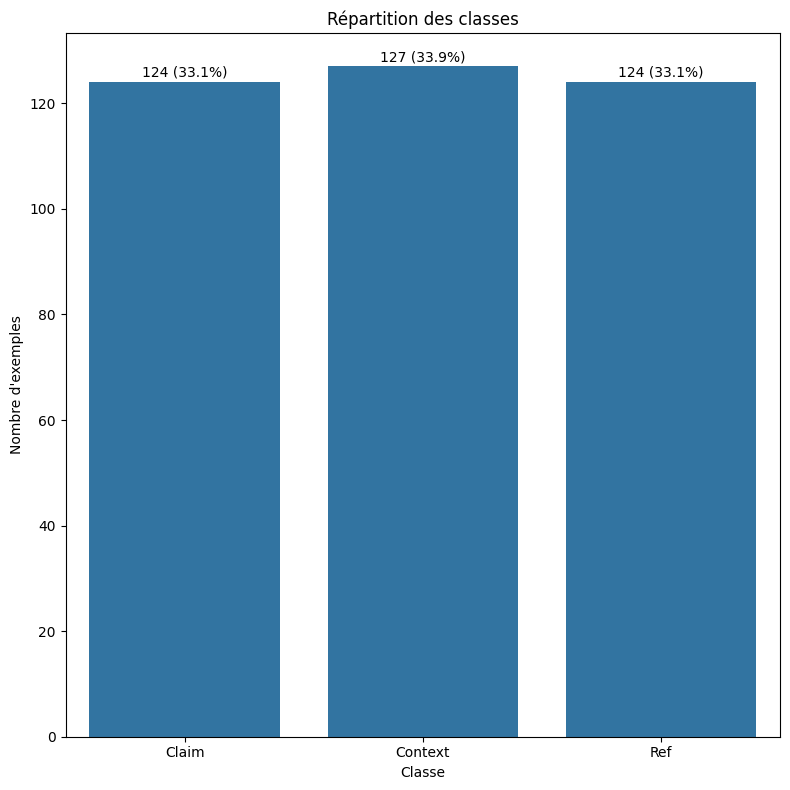

In [10]:
plt.figure(figsize=(8, 8))

counts = y.value_counts()
print(counts)
ax = sns.countplot(x=y)

for i in range(3):
    percentage = (counts[i] / len(df)) * 100
    ax.text(i, counts[i] + 1, f"{counts[i]} ({percentage:.1f}%)", ha='center')

plt.title("Répartition des classes")
plt.xlabel("Classe")
plt.xticks([0,1,2],["Claim","Context","Ref"])
plt.ylabel("Nombre d'exemples")
plt.tight_layout()
plt.show()


ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


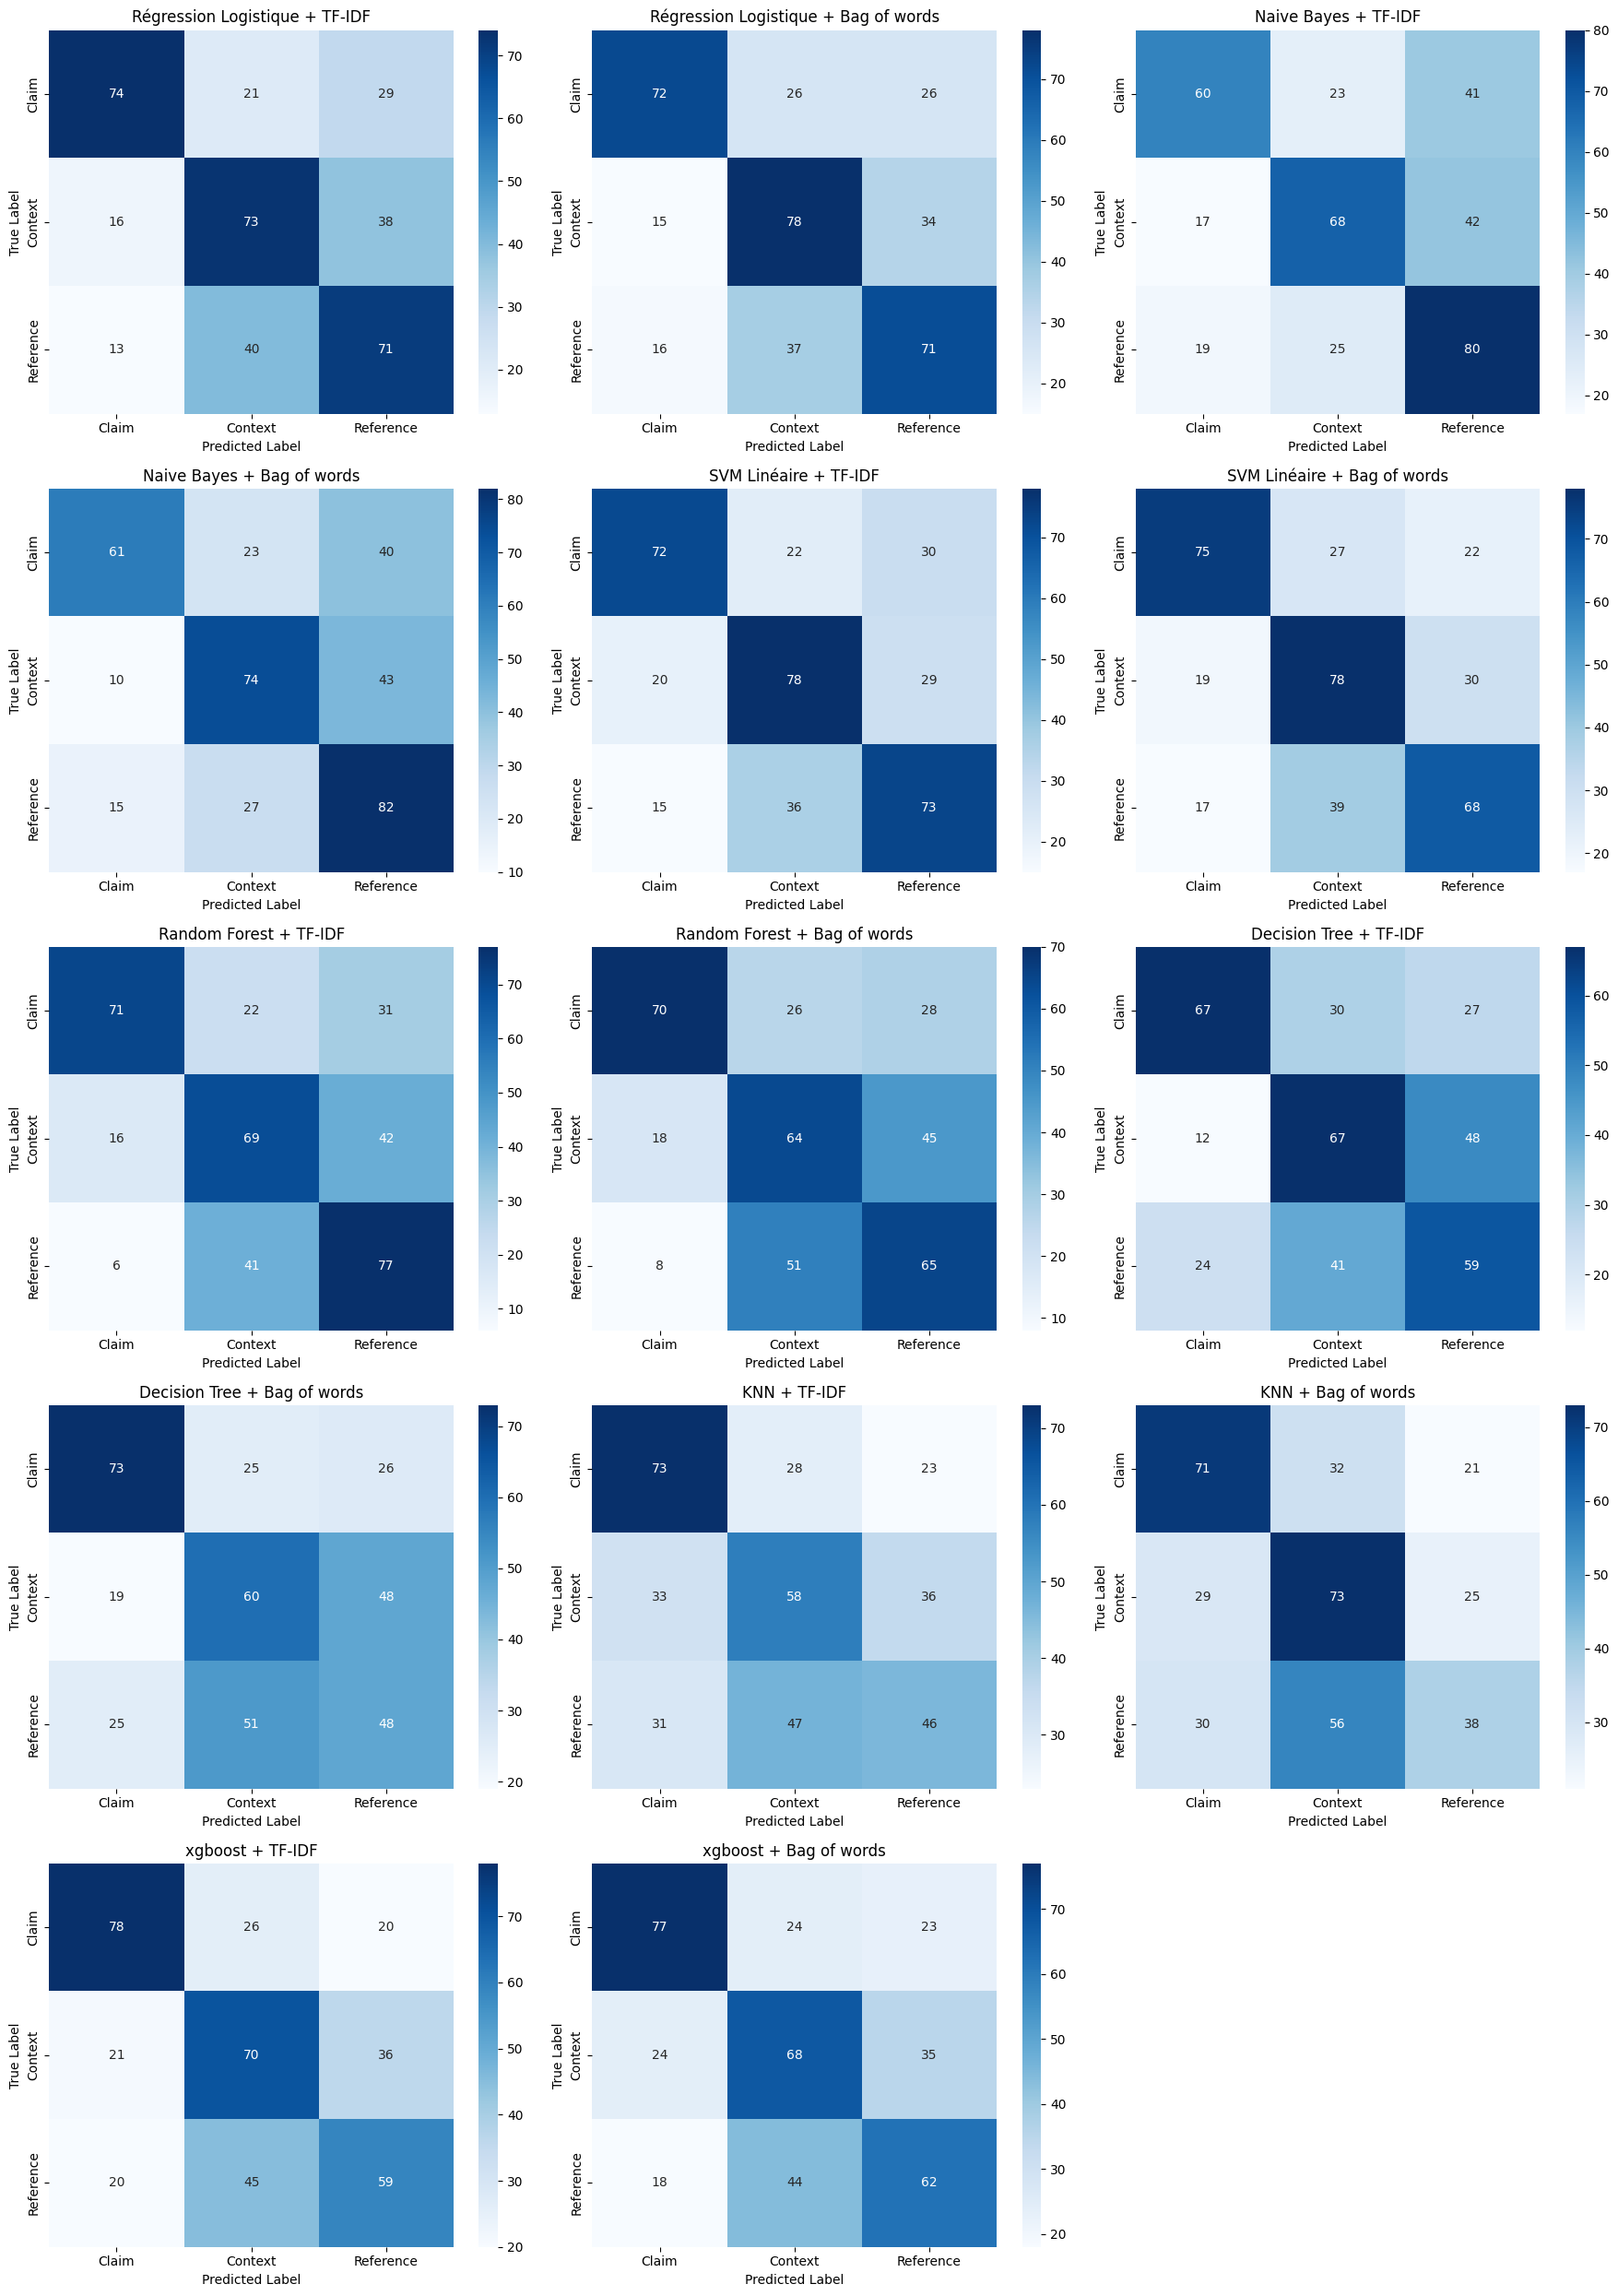

,Classifier,Vectorizer,F1 Mean,F1 Std
4,SVM Linéaire,TF-IDF,0.594,0.068
5,SVM Linéaire,Bag of words,0.588,0.048
1,Régression Logistique,Bag of words,0.587,0.050
0,Régression Logistique,TF-IDF,0.582,0.041
6,Random Forest,TF-IDF,0.582,0.024
3,Naive Bayes,Bag of words,0.578,0.068
13,xgboost,Bag of words,0.553,0.038
2,Naive Bayes,TF-IDF,0.552,0.058
12,xgboost,TF-IDF,0.552,0.058
7,Random Forest,Bag of words,0.536,0.023


In [11]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X, y, KeywordFeatures(15), config, x_ticks)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

## Le choix de mes Classifiers

1. SVM Linéaire & TF-IDF / Bag of words
2. Régression Logistique & TF-IDF / Bag of word
3. Random Forest & TF-IDF

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)
X_train.head()

print(f"Nous avons {X_train.shape[0]} tweets d'entrainements et {X_test.shape[0]} de test")

Nous avons 300 tweets d'entrainements et 75 de test


#### définitions de fonctions

In [13]:
ngram_options = {
	"unigram": (1, 1),
	"bigram": (1, 2),
	"trigram": (1, 3),
	"quadrugram": (1, 4)
}
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

text_col = "text"

In [14]:
def visualize_data_with_pca(X_test, y_test, pipeline, title="PCA des données", n_components = 2):
	"""
	Visualise les données transformées avec PCA et colore par classe
	"""
	# 1. Transformer les données avec le préprocesseur du pipeline
	preprocessor = pipeline.named_steps['preprocessor']
	X_transformed = preprocessor.transform(X_test)
	
	# Si la matrice est sparse, la convertir en dense
	if hasattr(X_transformed, "toarray"):
		X_dense = X_transformed.toarray()
	else:
		X_dense = X_transformed
	
	# 2. Appliquer PCA pour réduire à 2 dimensions
	pca = PCA(n_components=n_components)
	X_pca = pca.fit_transform(X_dense)
	
	# 3. Créer un DataFrame pour la visualisation
	df_plot = pd.DataFrame({
		'PC1': X_pca[:, 0],
		'PC2': X_pca[:, 1],
		'Class': y_test.values
	})
	
	# 4. Visualiser avec un scatter plot
	plt.figure(figsize=(10, 8))
	sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Class', 
				   palette={0: "red", 1: "blue"},s=60)
	
	# 5. Ajouter des informations sur la variance expliquée
	explained_var = pca.explained_variance_ratio_
	plt.xlabel(f'PC1 ({explained_var[0]:.2%} variance expliquée)')
	plt.ylabel(f'PC2 ({explained_var[1]:.2%} variance expliquée)')
	plt.title(f'{title}\nVariance totale expliquée: {sum(explained_var):.2%}')
	
	# 6. Ajouter une légende
	plt.legend(title="Classe", labels=["Non-scientifique", "Scientifique"])
	
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.plot()

	return X_pca

from sklearn.utils import resample

def get_score(pipeline, n_iterations=100):
    f1_scores = []
    
    for i in range(n_iterations):
        indices = resample(range(len(X_test)), replace=True, n_samples=len(X_test))
        X_boot = X_test.iloc[indices] if hasattr(X_test, 'iloc') else X_test[indices]
        y_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]

        y_pred = pipeline.predict(X_boot)
        f1 = f1_score(y_boot, y_pred, average='macro')
        f1_scores.append(f1)
    
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    print(f"✅ F1-score (bootstrap sur test, {n_iterations} itérations): {f1_mean:.3f} ± {f1_std:.3f}")
    return f1_mean, f1_std

def get_vectorizer(vectorizer_type, ngram_key, min_df, max_features):
	if vectorizer_type == "tfidf":
		return TfidfVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)
	return CountVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)

def get_trial_score(classifier, vectorizer, n_keywords, scaling = True):
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, "text"),
			("num", StandardScaler() if scaling else "passthrough", numerical_cols)
		]
	)
	
	pipeline = Pipeline([
		("keywords", KeywordFeatures(n_keywords)),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	return  cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()


def get_pipeline(model, classifier, scaler = True):
	vectorizer = model.get_vectorizer()
	numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

	
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, text_col),
			("num", StandardScaler() if scaler else "passthrough", numerical_cols)
		]
	)

	return Pipeline([
		("keywords", KeywordFeatures(model.get_config("n_keywords"))),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

#### SVM Linéaire & TF-IDF / Bag of words

In [27]:
def objective(trial):
	C = trial.suggest_float("C", 1e-1, 10, log=True)
	penalty = trial.suggest_categorical("penalty", ["l2"])
	loss = trial.suggest_categorical("loss", ["squared_hinge"])
	
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf", "bow"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	classifier = LinearSVC(
        C=C,
        penalty=penalty,
        loss=loss,
        dual=True,
        random_state=config.random_state,
        max_iter=40_000
    )

	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)


study = optuna.create_study(direction="maximize")

[I 2025-05-06 20:55:56,458] A new study created in memory with name: no-name-66c61034-4d19-4bfa-990e-4ee2e4399c62


In [29]:
study.optimize(objective, n_trials=60)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("SVM_Lineaire", study.best_params)

[I 2025-05-06 20:56:40,060] Trial 60 finished with value: 0.5832879455481644 and parameters: {'C': 8.82248816645232, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 2, 'max_features': 11000, 'n_keywords': 30}. Best is trial 10 with value: 0.6471612886442797.
[I 2025-05-06 20:56:40,538] Trial 61 finished with value: 0.6471612886442797 and parameters: {'C': 9.927478130601374, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 12000, 'n_keywords': 30}. Best is trial 10 with value: 0.6471612886442797.
[I 2025-05-06 20:56:41,063] Trial 62 finished with value: 0.6471612886442797 and parameters: {'C': 7.526844180442914, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 12000, 'n_keywords': 30}. Best is trial 10 with value: 0.6471612886442797.
[I 2025-05-06 20:56:41,538] Trial 63 finished w

Best f1_macro: 0.6471612886442797
Best params: {'C': 9.89794256204728, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 14000, 'n_keywords': 30}
✅  Model (SVM_Lineaire) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.617 ± 0.057


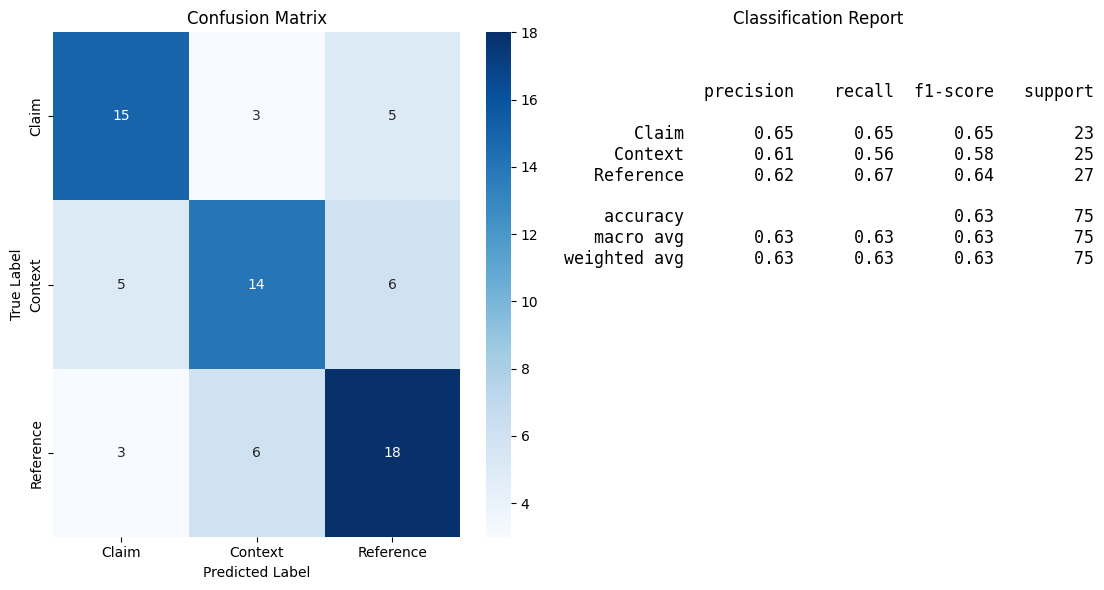

✅ Results saved to: ../results/Step3/SVM_Lineaire


In [15]:
model = config.get_model("SVM_Lineaire")

classifier = LinearSVC(
        C=model.get_config("C"),
        penalty=model.get_config("penalty"),
        loss=model.get_config("loss"),
        dual=True,
        random_state=config.random_state,
        max_iter=40_000
    )


pipeline_Xboost = get_pipeline(model, classifier)

pipeline_Xboost.fit(X_train, y_train)

y_pred = pipeline_Xboost.predict(X_test)

f1_m, f1_std = get_score(pipeline_Xboost)
fig = display_result(y_pred, y_test, x_ticks)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)


Ce modèle à des soucis d'itération et ne converge pas tout le temps, il y a beaucoup de souci de stabilité..

#### Régression Logistique & TF-IDF / Bag of word

In [35]:
def objective(trial):
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf", "bow"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 6)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 0, 30, step=5)
	
	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-3, 100.0, log=True)
	penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
	solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

	if penalty == "l1" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()

	if penalty == "l2" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()
	
	classifier = LogisticRegression(
		C=C,
		penalty=penalty,
		solver=solver,
		random_state=config.random_state,
		class_weight='balanced',
		max_iter=5000
	)
	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)

	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 20:59:32,772] A new study created in memory with name: no-name-37071044-9b48-4ca7-af1d-4d22fac0e128


In [38]:
study.optimize(objective, n_trials=60)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("Regression logistique", study.best_params)

[I 2025-05-06 21:02:09,593] Trial 60 finished with value: 0.5650649985237255 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 1, 'max_features': 9000, 'n_keywords': 15, 'C': 37.74468632767033, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 33 with value: 0.6149416239912636.
[I 2025-05-06 21:02:10,638] Trial 61 finished with value: 0.614243675336914 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 2, 'max_features': 9000, 'n_keywords': 20, 'C': 62.58884804506005, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 33 with value: 0.6149416239912636.
[I 2025-05-06 21:02:11,763] Trial 62 finished with value: 0.614243675336914 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 2, 'max_features': 10000, 'n_keywords': 20, 'C': 70.57131359829458, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 33 with value: 0.6149416239912636.
[I 2025-05-06 21:02:12,804] Trial 63 finished with value: 0.61424367533

Best f1_macro: 0.6237152229142998
Best params: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 2, 'max_features': 14000, 'n_keywords': 10, 'C': 12.651371551861654, 'penalty': 'l2', 'solver': 'saga'}
✅  Model (Regression logistique) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.633 ± 0.059


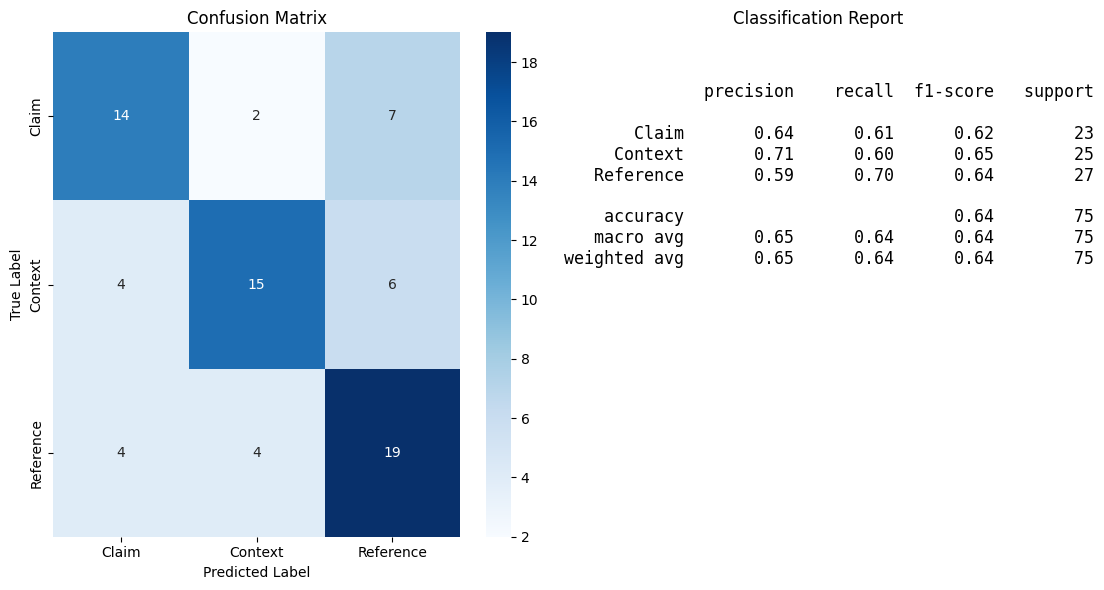

✅ Results saved to: ../results/Step3/Regression logistique


In [19]:
model = config.get_model("Regression logistique")
classifier = LogisticRegression(
        C = model.get_config("C"),
		penalty = model.get_config("penalty"),
        solver = model.get_config("solver"),
        class_weight = "balanced",
        random_state = config.random_state,
        max_iter = 4000
    )

pipeline_RL = get_pipeline(model, classifier)

pipeline_RL.fit(X_train, y_train)
y_pred = pipeline_RL.predict(X_test)

f1_m, f1_std = get_score(pipeline_RL)
fig = display_result(y_pred, y_test, x_ticks)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)

#### Random Forest & TF-IDF

In [20]:
def objective(trial):
	# Hyperparamètres texte
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow", "tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Random Forest
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 5, 50)
	min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

	bootstrap = trial.suggest_categorical("bootstrap", [True, False])
	max_features_model = trial.suggest_categorical("max_features_model", ['sqrt', 'log2', None])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	
	classifier = RandomForestClassifier(
		n_estimators=n_estimators,
		max_depth=max_depth,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		random_state=config.random_state,
		max_features= max_features_model,
		bootstrap = bootstrap,
		class_weight='balanced'
	)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 21:21:51,156] A new study created in memory with name: no-name-93326166-b669-47c8-b774-5c45019e7235


In [21]:
study.optimize(objective, n_trials=50)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("Random Forest", study.best_params)

[I 2025-05-06 21:22:02,370] Trial 0 finished with value: 0.5895707202873589 and parameters: {'vectorizer_type': 'bow', 'ngram_range': 'unigram', 'min_df': 4, 'max_features': 6000, 'n_estimators': 700, 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features_model': 'sqrt', 'n_keywords': 25}. Best is trial 0 with value: 0.5895707202873589.
[I 2025-05-06 21:22:08,697] Trial 1 finished with value: 0.5572995648495337 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 5, 'max_features': 18000, 'n_estimators': 700, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features_model': None, 'n_keywords': 20}. Best is trial 0 with value: 0.5895707202873589.
[I 2025-05-06 21:22:11,950] Trial 2 finished with value: 0.5863990144228007 and parameters: {'vectorizer_type': 'bow', 'ngram_range': 'unigram', 'min_df': 6, 'max_features': 14000, 'n_estimators': 700, 'max_depth': 24, 'min_samples_split'

Best f1_macro: 0.6034189475254682
Best params: {'vectorizer_type': 'bow', 'ngram_range': 'unigram', 'min_df': 2, 'max_features': 11000, 'n_estimators': 900, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features_model': 'sqrt', 'n_keywords': 15}
✅  Model (Random Forest) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.606 ± 0.057


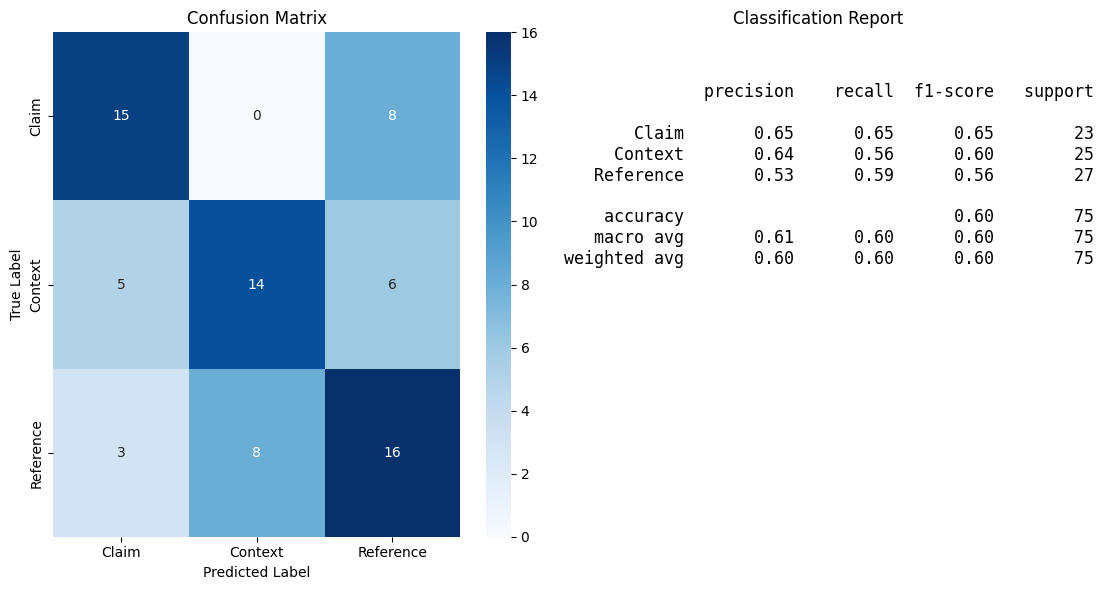

✅ Results saved to: ../results/Step3/Random Forest


In [22]:
model = config.get_model("Random Forest")
classifier = RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		bootstrap = model.get_config("bootstrap"),
		max_features = model.get_config("max_features_model"),
		random_state = config.random_state,
		class_weight='balanced'
	)

pipeline_RF = get_pipeline(model, classifier)

pipeline_RF.fit(X_train, y_train)
y_pred = pipeline_RF.predict(X_test)

f1_m, f1_std = get_score(pipeline_RF)
fig = display_result(y_pred, y_test, x_ticks)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)